# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pandas as pd
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


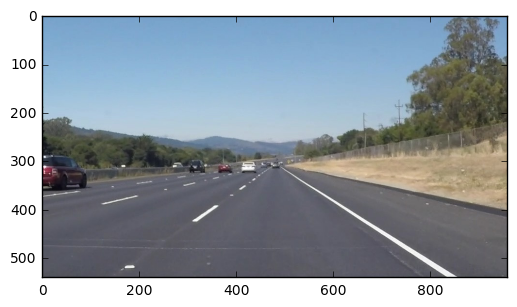

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [108]:
import math

def weighted_average(value):
    """ Do not forget to put something in place in case a weight does not exist.   Also, cover for 0.
    Assign a global variable? If so check here 
    http://stackoverflow.com/questions/423379
    /using-global-variables-in-a-function-other-than-the-one-that-created-them"""
        
# for each x1,y1,x2,y2 ?
# ( (some_value * number of records) / number of records )

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lanes = []
    right_lanes = []
    top_y = image.shape[0]
    
    for line in lines:

        for x1,y1,x2,y2 in line:

                slope = (y2-y1) / (x2-x1)

                if slope > 0:
  
                    right_lanes.append([x1,y1,x2,y2])

                else:
                    
                    left_lanes.append([x1,y1,x2,y2])


#         print('Y1 :',y1,' Y2 :',y2)
        if y1 < y2:
            if top_y > y1:
                top_y = y1
       
    # Work with individual lanes
    if len(left_lanes) > 0:

#         counter = 0

        for lane in left_lanes:
            
            slope = ((lane[3] - lane[1]) / (lane[2] - lane[0]))
            # Slope 0 produces an infinity error
            if slope != 0:

                top_x = lane[0] + (top_y - lane[1]) / slope
                bottom_x = lane[0] + (img.shape[0] - lane[1]) / slope

                # Draw beginning and end points
#                 cv2.circle(img,(int(top_x),int(top_y)), 10, (255,255,0), -1)
#                 cv2.circle(img,(int(bottom_x),image.shape[0]), 10, (255,255,0), -1)
              
#         old_x1 = lane[0]
#         old_y1 = lane[1]
#         old_x2 = lane[2]
#         old_y2 = lane[3]
#         counter = counter + 1

        cv2.line(img, (int(bottom_x), img.shape[0]), (int(top_x), int(top_y)), color, thickness)

    # Work with individual lanes
    if len(right_lanes) > 0:   
#         counter = 0

        for lane in right_lanes:
            slope = ((lane[3] - lane[1]) / (lane[2] - lane[0]))
            # Slope 0 produces an infinity error
            if slope != 0:

                top_x = lane[0] + (top_y - lane[1]) / slope
                bottom_x = lane[0] + (img.shape[0] - lane[1]) / slope   
                
                # Draw beginning and end points
#                 cv2.circle(img,(int(top_x),int(top_y)), 10, (255,255,0), -1)
#                 cv2.circle(img,(int(bottom_x),image.shape[0]), 10, (255,255,0), -1)
                
#         old_x1 = lane[0]
#         old_y1 = lane[1]
#         old_x2 = lane[2]
#         old_y2 = lane[3]
#         counter = counter + 1

        cv2.line(img, (int(bottom_x), img.shape[0]), (int(top_x), int(top_y)), color, thickness)
    
        # Line going up the middle
#         cv2.line(img, ((int(image.shape[1]/2), img.shape[0])), ((int(image.shape[1]/2)), int(top_y)), [0,0,255], 1)


            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

# def color_filter(image):
#     images = []
#     for i in [0,1,2]:
#         color = image.copy()
#         if i != 0: color[:,:,0] = 0
#         if i != 1: color[:,:,1] = 0
#         if i != 2: color[:,:,2] = 0
            
#         images.append(color)
       
#     return plt.imshow(np.vstack(images))  
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [46]:
import os
os.listdir("test_images/")

['.DS_Store',
 '8PVCyHhdrmMw0AAAAASUVORK5CYII=.png',
 'AAAAAElFTkSuQmCC.png',
 'cAAAAASUVORK5CYII=.png',
 'curved lane.jpg',
 'h8Wa8UTc67jygAAAABJRU5ErkJggg==.png',
 'Lzf7y8BmY1BtSWUgJUnSBtfWewokSVJ1TAokSRJgUiBJkgqTAkmSBJgUSJKkwqRAkiQBJgWSJKkwKZAkSYBJgSRJKkwKJEkSYFIgSZKK34MT75qt80DZAAAAAElFTkSuQmCC.png',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'test runs',
 'WFz3+X3v1kAAAAAElFTkSuQmCC.png',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

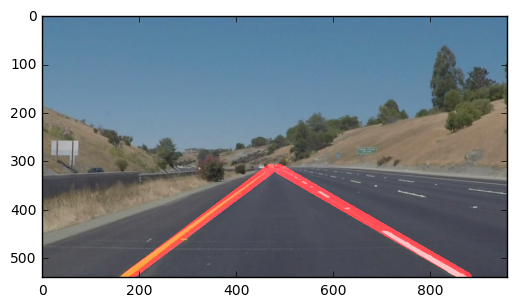

In [208]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Run a color filter
#     color_filter(image)
    
    # turn to gray image
    gray = grayscale(image)
    
    # smooth
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # edge detect
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # set a region that should contain line
    imshape = image.shape
    
    # This will need to be dynamic most likely
    vertices = np.array([[(50,imshape[0]),(450, 325), (490, 315), (900,imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    
    #  Scale rho, theta values up to be more flexible in your definition of what constitutes a line.
    rho = 1                         # distance resolution in pixels of the Hough grid
    theta = np.pi/180               # angular resolution in radians of the Hough grid
    threshold = 55                 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 130            # minimum number of pixels making up a line
    max_line_gap = 100                # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0   #creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_img = hough_lines(masked_edges, rho, theta, threshold,
                            min_line_length, max_line_gap)
    
    result = weighted_img(line_img, image)
    
    return result

test_imgs = ['whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg']

ex_img = mpimg.imread('test_images/' + test_imgs[5])

result = process_image(ex_img)

plt.imshow(result, cmap='Greys_r')
# src = mpimg.imread('test_images/curved lane.jpg')
# result = process_image(src)
# plt.imshow(color_img)

Let's try the one with the solid white lane on the right first ...

In [204]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

  2%|▏         | 4/222 [00:00<00:05, 38.32it/s]

  4%|▎         | 8/222 [00:00<00:05, 38.10it/s]

  5%|▌         | 12/222 [00:00<00:05, 36.83it/s]

  8%|▊         | 17/222 [00:00<00:05, 39.14it/s]

 10%|▉         | 22/222 [00:00<00:04, 41.70it/s]

 12%|█▏        | 26/222 [00:00<00:04, 40.54it/s]

 14%|█▎        | 30/222 [00:00<00:05, 35.96it/s]

 15%|█▌        | 34/222 [00:00<00:05, 35.02it/s]

 17%|█▋        | 38/222 [00:01<00:05, 34.66it/s]

 19%|█▉        | 42/222 [00:01<00:05, 34.26it/s]

 21%|██        | 46/222 [00:01<00:05, 34.55it/s]

 23%|██▎       | 50/222 [00:01<00:05, 30.21it/s]

 24%|██▍       | 54/222 [00:01<00:05, 29.98it/s]

 26%|██▌       | 58/222 [00:01<00:05, 28.66it/s]

 27%|██▋       | 61/222 [00:01<00:06, 26.77it/s]

 29%|██▉       | 64/222 [00:02<00:06, 22.89it/s]

 30%|███       | 67/222 [00:02<00:06, 23.23it/s]

 32%|███▏      | 70/222 [00:02<00:06, 24.33it/s]

 33%|███▎      | 73/222 [00:02<00:06, 23.04it/s]

 34%|███▍

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.13 s, sys: 1.23 s, total: 4.36 s
Wall time: 8.34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [209]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [210]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4




  0%|          | 0/682 [00:00<?, ?it/s]

  0%|          | 3/682 [00:00<00:27, 24.38it/s]

  1%|          | 6/682 [00:00<00:26, 25.73it/s]

  2%|▏         | 11/682 [00:00<00:22, 29.94it/s]

  2%|▏         | 15/682 [00:00<00:20, 31.90it/s]

  3%|▎         | 20/682 [00:00<00:18, 34.88it/s]

  4%|▍         | 26/682 [00:00<00:16, 38.64it/s]

  5%|▍         | 31/682 [00:00<00:15, 41.06it/s]

  5%|▌         | 36/682 [00:00<00:15, 43.05it/s]

  6%|▌         | 42/682 [00:00<00:14, 45.68it/s]

  7%|▋         | 47/682 [00:01<00:15, 41.88it/s]

  8%|▊         | 52/682 [00:01<00:17, 37.03it/s]

  8%|▊         | 56/682 [00:01<00:23, 26.53it/s]

  9%|▉         | 60/682 [00:01<00:25, 24.81it/s]

  9%|▉         | 63/682 [00:01<00:27, 22.31it/s]

 10%|▉         | 66/682 [00:02<00:28, 21.63it/s]

 10%|█         | 69/682 [00:02<00:26, 22.88it/s]

 11%|█         | 72/682 [00:02<00:26, 22.98it/s]

 11%|█         | 75/682 [00:02<00:26, 23.01it/s]

 11%|█▏        | 78/682 [00:02<00:25, 23.48it/s]

 12%|█▏  

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10 s, sys: 3.75 s, total: 13.8 s
Wall time: 25.8 s


In [211]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### Summary

At this stage my pipleine is very basic.  I seperated the right and left lanes based on their slope.  Then I plot out the outer most endpoints and draw lines connecting those points.  The lines plot onto the image and videos well, but not exceptionally well.

* Improvements

 * How it can be better
 
   * The lines are not as smooth as the sample video.  I have seen many postings on the forums and discussions on blogs  discussing how to achieve this but was unalbe to develop anything in time for submission.  Drawing smooth lane lines is the first thing I want to improve on.
 
   * I came across a post in the forums discussing the "quality" of the lines and that was an interesting idea to me.  There was also a video from that same user (I believe although I cannot find it now) and in the video the lines drawn had an outer line around them that flickered on and off to show (what I can only assume to be) the strength of the particular line data at that point.  It became obvious to me how nessecary it will be to extend this beyond the basic function of just returning the lane lines, and actually trying to gather as much insight from the surrounding environment as possible.
 
   * Developing a way to understand more about the colors present in the image will also make this stronger.  Not all edges are equal and so understanding that the lane lines are yellow, or white, or whatever they may be would help with adjusting the settings in order to detect those edges with highest level of accuracy.

   * I also think that tracking other lines may be useful as well.  I was unable to complete the challenge video but as I tried it became clear to me that I was picking up edges, just not the edges I wanted.  the lines were jumping all over and so, along with the improvements above, perhaps gathering data and trying to plot other, very strong edges, might help improve the pipline's accuracy and usefulness.
   * I think it would also be useful to track and store data as a way to add some intelligance to the lane finding process over time.
 
  * Where it will fail
    * The first and most obvious shortcoming is how jittery it is.  Smooth, consistant lines are not only nicer to look at, but provide a more consistant picture of what is happening I feel.  Mine just switch from image to image without understaning what came before them and that is not where I ultimately want this to be.
    
    *  Just from viewing the challenge video it is clear that it will fail under conditions that are not as ideal as what the images and first two videos provide.  As it stands, even in daylight it still doe snot detect the lines with accuracy and that is a massive failing point. 
    


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [58]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Top x weighted : 470.282352941
Bottom x weighted : 202.4
Top x weighted : -1656.5
Bottom x weighted : -5166.5
Top x weighted : 483.333333333
Bottom x weighted : 219.333333333
Top x weighted : 481.294117647
Bottom x weighted : 231.411764706
Top x weighted : 4896.0
Bottom x weighted : -864.0
Top x weighted : -1103.0
Bottom x weighted : -3623.0
Top x weighted : 186.0
Bottom x weighted : -534.0
Top x weighted : 478.111111111
Bottom x weighted : 218.111111111
Top x weighted : -1691.0
Bottom x weighted : -5111.0
Top x weighted : 479.363636364
Bottom x weighted : 201.181818182
Top x weighted : 481.6
Bottom x weighted : 233.2
Top x weighted : 194.0
Bottom x weighted : -526.0
Top x weighted : 195.0
Bottom x weighted : -525.0
Top x weighted : 224.0
Bottom x weighted : -436.0
Top x weighted : 225.0
Bottom x weighted : -435.0
Top x weighted : 223.909090909
Bottom x weighted : -414.272727273
Top x weighted : 481.5
Bottom x weighted : 211.5
Top x weighted : 191.0
Bottom x weighted : -529.0
Top x wei

  1%|          | 3/251 [00:00<00:10, 23.20it/s]

Top x weighted : 470.282352941
Bottom x weighted : 202.4
Top x weighted : -1656.5
Bottom x weighted : -5166.5
Top x weighted : 483.333333333
Bottom x weighted : 219.333333333
Top x weighted : 481.294117647
Bottom x weighted : 231.411764706
Top x weighted : 4896.0
Bottom x weighted : -864.0
Top x weighted : -1103.0
Bottom x weighted : -3623.0
Top x weighted : 186.0
Bottom x weighted : -534.0
Top x weighted : 478.111111111
Bottom x weighted : 218.111111111
Top x weighted : -1691.0
Bottom x weighted : -5111.0
Top x weighted : 479.363636364
Bottom x weighted : 201.181818182
Top x weighted : 481.6
Bottom x weighted : 233.2
Top x weighted : 194.0
Bottom x weighted : -526.0
Top x weighted : 195.0
Bottom x weighted : -525.0
Top x weighted : 224.0
Bottom x weighted : -436.0
Top x weighted : 225.0
Bottom x weighted : -435.0
Top x weighted : 223.909090909
Bottom x weighted : -414.272727273
Top x weighted : 481.5
Bottom x weighted : 211.5
Top x weighted : 191.0
Bottom x weighted : -529.0
Top x wei

  3%|▎         | 8/251 [00:00<00:12, 19.24it/s]

Top x weighted : 490.197183099
Bottom x weighted : 234.14084507
Top x weighted : 477.0
Bottom x weighted : 207.0
Top x weighted : -2166.0
Bottom x weighted : -6486.0
Top x weighted : 214.0
Bottom x weighted : -470.0
Top x weighted : -754.0
Bottom x weighted : -2734.0
Top x weighted : 475.027027027
Bottom x weighted : 207.459459459
Top x weighted : 234.25
Bottom x weighted : -418.25
Top x weighted : 487.774193548
Bottom x weighted : 226.483870968
Top x weighted : 213.0
Bottom x weighted : -477.0
Top x weighted : 478.074074074
Bottom x weighted : 211.407407407
Top x weighted : 6567.0
Bottom x weighted : -1713.0
Top x weighted : 3346.0
Bottom x weighted : -434.0
Top x weighted : 231.0
Bottom x weighted : -489.0
Top x weighted : 472.647058824
Bottom x weighted : 186.764705882
Top x weighted : -2511.0
Bottom x weighted : -7191.0
Top x weighted : 3955.0
Bottom x weighted : -725.0
Top x weighted : 140.0
Bottom x weighted : -670.0
Top x weighted : 217.0
Bottom x weighted : -503.0
Top x weighte

  4%|▍         | 11/251 [00:00<00:12, 19.87it/s]

Top x weighted : 478.02970297
Bottom x weighted : 221.396039604
Top x weighted : 490.076923077
Bottom x weighted : 251.230769231
Top x weighted : 477.619047619
Bottom x weighted : 211.904761905
Top x weighted : 218.789473684
Bottom x weighted : -463.315789474
Top x weighted : 209.5
Bottom x weighted : -465.5
Top x weighted : -797.5
Bottom x weighted : -2867.5
Top x weighted : 225.774193548
Bottom x weighted : -407.129032258
Top x weighted : -2863.0
Bottom x weighted : -8263.0
Top x weighted : 488.057142857
Bottom x weighted : 251.485714286
Top x weighted : 474.0
Bottom x weighted : 186.0
Top x weighted : -709.5
Bottom x weighted : -2599.5
Top x weighted : 478.432432432
Bottom x weighted : 215.72972973
Top x weighted : 494.052631579
Bottom x weighted : 247.736842105
Top x weighted : 489.9375
Bottom x weighted : 234.0
Top x weighted : 240.888888889
Bottom x weighted : -379.111111111
Top x weighted : 6741.0
Bottom x weighted : -1359.0
Top x weighted : 475.813559322
Bottom x weighted : 198

  6%|▌         | 14/251 [00:00<00:11, 21.54it/s]

Top x weighted : 489.613095238
Bottom x weighted : 250.68452381
Top x weighted : 478.253731343
Bottom x weighted : 221.686567164
Top x weighted : 477.0625
Bottom x weighted : 221.125
Top x weighted : 217.5
Bottom x weighted : -412.5
Top x weighted : -893.0
Bottom x weighted : -3053.0
Top x weighted : 225.0
Bottom x weighted : -423.0
Top x weighted : 487.5625
Bottom x weighted : 251.3125
Top x weighted : 213.6
Bottom x weighted : -434.4
Top x weighted : -1726.0
Bottom x weighted : -5326.0
Top x weighted : 233.25
Bottom x weighted : -374.25
Top x weighted : 491.333333333
Bottom x weighted : 251.333333333
Top x weighted : 200.882352941
Bottom x weighted : -476.764705882
Top x weighted : 484.375
Bottom x weighted : 236.875
Top x weighted : 485.3
Bottom x weighted : 251.3
Top x weighted : 230.6
Bottom x weighted : -417.4
Top x weighted : 475.4
Bottom x weighted : 223.4
Top x weighted : -1339.0
Bottom x weighted : -4219.0
Top x weighted : 2213.0
Bottom x weighted : -127.0
Top x weighted : 47

  8%|▊         | 20/251 [00:00<00:09, 24.03it/s]

Top x weighted : 489.86407767
Bottom x weighted : 250.446601942
Top x weighted : 479.142857143
Bottom x weighted : 222.0
Top x weighted : -1488.0
Bottom x weighted : -4728.0
Top x weighted : 232.0
Bottom x weighted : -380.0
Top x weighted : 490.451612903
Bottom x weighted : 252.387096774
Top x weighted : 7816.0
Bottom x weighted : -2264.0
Top x weighted : 489.644444444
Bottom x weighted : 257.644444444
Top x weighted : 231.5
Bottom x weighted : -398.5
Top x weighted : 213.5
Bottom x weighted : -432.863636364
Top x weighted : 477.090909091
Bottom x weighted : 215.272727273
Top x weighted : -2505.0
Bottom x weighted : -7185.0
Top x weighted : 135.5
Bottom x weighted : -674.5
Top x weighted : 87.0
Bottom x weighted : -813.0
Top x weighted : 217.6
Bottom x weighted : -448.4
Top x weighted : 228.083333333
Bottom x weighted : -386.916666667
Top x weighted : 482.0
Bottom x weighted : 212.0
Top x weighted : 474.72
Bottom x weighted : 201.12
Top x weighted : 216.75
Bottom x weighted : -458.25
T

 10%|█         | 26/251 [00:01<00:08, 25.08it/s]

Top x weighted : 488.589041096
Bottom x weighted : 249.410958904
Top x weighted : 475.973333333
Bottom x weighted : 221.573333333
Top x weighted : 475.46875
Bottom x weighted : 219.53125
Top x weighted : 4419.0
Bottom x weighted : -981.0
Top x weighted : 226.555555556
Bottom x weighted : -413.444444444
Top x weighted : -1451.0
Bottom x weighted : -4511.0
Top x weighted : 213.384615385
Bottom x weighted : -437.384615385
Top x weighted : 483.649122807
Bottom x weighted : 253.122807018
Top x weighted : -1244.33333333
Bottom x weighted : -4064.33333333
Top x weighted : 154.0
Bottom x weighted : -626.0
Top x weighted : 209.235294118
Bottom x weighted : -447.235294118
Top x weighted : 486.390243902
Bottom x weighted : 253.707317073
Top x weighted : 478.966666667
Bottom x weighted : 220.966666667
Top x weighted : 228.761904762
Bottom x weighted : -405.523809524
Top x weighted : 475.121212121
Bottom x weighted : 207.848484848
Top x weighted : -1692.0
Bottom x weighted : -5112.0
Top x weighted 

 13%|█▎        | 32/251 [00:01<00:08, 25.35it/s]

Top x weighted : 708.054794521
Bottom x weighted : 249.095890411
Top x weighted : 705.619047619
Bottom x weighted : 223.666666667
Top x weighted : 709.2
Bottom x weighted : 246.775
Top x weighted : 861.0
Bottom x weighted : -535.0
Top x weighted : 862.2
Bottom x weighted : -464.0
Top x weighted : 804.980392157
Bottom x weighted : -413.098039216
Top x weighted : 1738.0
Bottom x weighted : -5591.0
Top x weighted : 816.5
Bottom x weighted : -405.0
Top x weighted : 833.75
Bottom x weighted : -475.0
Top x weighted : 763.833333333
Bottom x weighted : 124.0
Top x weighted : 733.4
Bottom x weighted : 186.633333333
Top x weighted : 793.666666667
Bottom x weighted : -369.666666667
Top x weighted : 1930.0
Bottom x weighted : -6795.0
Top x weighted : 746.666666667
Bottom x weighted : 165.0
Top x weighted : 689.25
Bottom x weighted : 253.0
Top x weighted : 860.0
Bottom x weighted : -536.0
Top x weighted : 742.0
Bottom x weighted : 183.6
Top x weighted : 713.666666667
Bottom x weighted : -275.166666

 14%|█▍        | 35/251 [00:01<00:09, 23.23it/s]

Top x weighted : 764.0
Bottom x weighted : 240.625
Top x weighted : 791.987951807
Bottom x weighted : 201.86746988
Top x weighted : 781.322580645
Bottom x weighted : 233.419354839
Top x weighted : 1016.0
Bottom x weighted : -485.0
Top x weighted : 3831.0
Bottom x weighted : -8414.0
Top x weighted : 1344.0
Bottom x weighted : -1026.0
Top x weighted : 1061.0
Bottom x weighted : -519.0
Top x weighted : 1048.0
Bottom x weighted : -532.0
Top x weighted : 2409.0
Bottom x weighted : -5096.0
Top x weighted : 821.365853659
Bottom x weighted : 185.512195122
Top x weighted : 775.987341772
Bottom x weighted : 235.987341772
Top x weighted : 799.176470588
Bottom x weighted : 195.058823529
Top x weighted : 773.265306122
Bottom x weighted : 213.010204082
Top x weighted : 6396.0
Bottom x weighted : -319.0
Top x weighted : 1084.0
Bottom x weighted : -594.75
Top x weighted : 1174.0
Bottom x weighted : -801.0
Top x weighted : 1057.0
Bottom x weighted : -523.0
Top x weighted : 1151.66666667
Bottom x weight

 15%|█▌        | 38/251 [00:01<00:10, 20.65it/s]

Top x weighted : 792.829545455
Bottom x weighted : 204.096590909
Top x weighted : 792.25
Bottom x weighted : 229.833333333
Top x weighted : 1073.0
Bottom x weighted : -515.0
Top x weighted : 1060.0
Bottom x weighted : -528.0
Top x weighted : 788.65625
Bottom x weighted : 230.375
Top x weighted : 12383.0
Bottom x weighted : -1115.0
Top x weighted : 3666.0
Bottom x weighted : -7847.0
Top x weighted : 1105.0
Bottom x weighted : -615.333333333
Top x weighted : 805.111111111
Bottom x weighted : 214.022222222
Top x weighted : 836.525
Bottom x weighted : 151.7
Top x weighted : 2561.0
Bottom x weighted : -5379.0
Top x weighted : 763.6
Bottom x weighted : 207.8
Top x weighted : 2058.0
Bottom x weighted : -3897.0
Top x weighted : 791.64516129
Bottom x weighted : 202.548387097
Top x weighted : 866.461538462
Bottom x weighted : 118.269230769
Top x weighted : 1086.0
Bottom x weighted : -581.4
Top x weighted : 1803.0
Bottom x weighted : -2961.0
Top x weighted : 1007.90909091
Bottom x weighted : -435

 16%|█▋        | 41/251 [00:01<00:10, 20.04it/s]

Top x weighted : 801.705035971
Bottom x weighted : 204.45323741
Top x weighted : 792.096774194
Bottom x weighted : 233.096774194
Top x weighted : 1086.0
Bottom x weighted : -526.0
Top x weighted : 1120.0
Bottom x weighted : -592.75
Top x weighted : 1103.0
Bottom x weighted : -509.0
Top x weighted : 3545.0
Bottom x weighted : -7336.0
Top x weighted : 1102.0
Bottom x weighted : -510.0
Top x weighted : 1122.66666667
Bottom x weighted : -556.5
Top x weighted : 801.565789474
Bottom x weighted : 202.368421053
Top x weighted : 774.2
Bottom x weighted : 210.0
Top x weighted : 4104.0
Bottom x weighted : -8389.0
Top x weighted : 826.0
Bottom x weighted : 204.708333333
Top x weighted : 1059.8
Bottom x weighted : -471.6
Top x weighted : 768.048780488
Bottom x weighted : 237.268292683
Top x weighted : 840.671641791
Bottom x weighted : 167.0
Top x weighted : 1090.0
Bottom x weighted : -522.0
Top x weighted : 1728.0
Bottom x weighted : -2705.0
Top x weighted : 1100.0
Bottom x weighted : -512.0
Top x 

 18%|█▊        | 44/251 [00:02<00:11, 18.11it/s]

Top x weighted : 808.861271676
Bottom x weighted : 232.052023121
Top x weighted : 821.275229358
Bottom x weighted : 198.596330275
Top x weighted : 819.936708861
Bottom x weighted : 201.151898734
Top x weighted : 1104.0
Bottom x weighted : -512.0
Top x weighted : 1051.64516129
Bottom x weighted : -460.096774194
Top x weighted : 1070.0
Bottom x weighted : -445.0
Top x weighted : 3790.0
Bottom x weighted : -7522.0
Top x weighted : 1092.0
Bottom x weighted : -524.0
Top x weighted : 3539.0
Bottom x weighted : -7369.0
Top x weighted : 1107.0
Bottom x weighted : -509.0
Top x weighted : 1054.66666667
Bottom x weighted : -426.666666667
Top x weighted : 1039.66666667
Bottom x weighted : -441.666666667
Top x weighted : 820.578947368
Bottom x weighted : 203.947368421
Top x weighted : 1068.55555556
Bottom x weighted : -457.666666667
Top x weighted : 800.2
Bottom x weighted : 234.6
Top x weighted : 3093.0
Bottom x weighted : -6199.0
Top x weighted : 1092.71428571
Bottom x weighted : -465.571428571
T

 18%|█▊        | 46/251 [00:02<00:12, 17.06it/s]

Top x weighted : 800.8
Bottom x weighted : 230.56
Top x weighted : 799.015037594
Bottom x weighted : 209.481203008
Top x weighted : 1060.0
Bottom x weighted : -524.0
Top x weighted : 787.238095238
Bottom x weighted : 240.380952381
Top x weighted : 1062.0
Bottom x weighted : -522.0
Top x weighted : 786.0
Bottom x weighted : 238.340425532
Top x weighted : 1006.77777778
Bottom x weighted : -401.222222222
Top x weighted : 1034.0
Bottom x weighted : -470.8
Top x weighted : 1284.0
Bottom x weighted : -696.0
Top x weighted : 1095.0
Bottom x weighted : -489.0
Top x weighted : 1075.0
Bottom x weighted : -509.0
Top x weighted : 4389.0
Bottom x weighted : -9471.0
Top x weighted : 1032.0
Bottom x weighted : -438.857142857
Top x weighted : 1020.14285714
Bottom x weighted : -422.428571429
Top x weighted : 787.660377358
Bottom x weighted : 242.226415094
Top x weighted : 783.377777778
Bottom x weighted : 237.777777778
Top x weighted : 1023.25
Bottom x weighted : -461.75
Top x weighted : 1019.375
Botto

 19%|█▉        | 48/251 [00:02<00:13, 15.48it/s]

Top x weighted : 797.617021277
Bottom x weighted : 212.120567376
Top x weighted : 1076.0
Bottom x weighted : -504.0
Top x weighted : 804.0
Bottom x weighted : 211.5
Top x weighted : 787.165680473
Bottom x weighted : 242.579881657
Top x weighted : 1008.66666667
Bottom x weighted : -439.666666667
Top x weighted : 1050.28571429
Bottom x weighted : -473.285714286
Top x weighted : 2809.0
Bottom x weighted : -5881.0
Top x weighted : 803.0
Bottom x weighted : 210.5
Top x weighted : 995.0
Bottom x weighted : -387.5
Top x weighted : 798.119266055
Bottom x weighted : 211.055045872
Top x weighted : 1005.14285714
Bottom x weighted : -405.571428571
Top x weighted : 2702.0
Bottom x weighted : -5593.0
Top x weighted : 1018.14285714
Bottom x weighted : -449.0
Top x weighted : 3120.0
Bottom x weighted : -6360.0
Top x weighted : 783.592592593
Bottom x weighted : 242.296296296
Top x weighted : 1053.92307692
Bottom x weighted : -495.692307692
Top x weighted : 852.875
Bottom x weighted : 112.25
Top x weigh

 20%|█▉        | 50/251 [00:02<00:14, 14.00it/s]

Top x weighted : 792.543478261
Bottom x weighted : 243.347826087
Top x weighted : 1045.75
Bottom x weighted : -458.0
Top x weighted : 808.221052632
Bottom x weighted : 213.052631579
Top x weighted : 794.046511628
Bottom x weighted : 243.837209302
Top x weighted : 1029.6
Bottom x weighted : -414.0
Top x weighted : 806.893442623
Bottom x weighted : 211.967213115
Top x weighted : 1895.0
Bottom x weighted : -3318.0
Top x weighted : 1208.0
Bottom x weighted : -797.0
Top x weighted : 2852.0
Bottom x weighted : -5569.0
Top x weighted : 1585.33333333
Bottom x weighted : -2558.33333333
Top x weighted : 981.0
Bottom x weighted : -355.666666667
Top x weighted : 19166.0
Bottom x weighted : -2087.0
Top x weighted : 1056.33333333
Bottom x weighted : -480.833333333
Top x weighted : 1031.0
Bottom x weighted : -412.6
Top x weighted : 1083.0
Bottom x weighted : -521.0
Top x weighted : 3651.0
Bottom x weighted : -7978.0
Top x weighted : 1004.52173913
Bottom x weighted : -407.695652174
Top x weighted : 10

 21%|██        | 52/251 [00:02<00:15, 12.55it/s]

Top x weighted : 812.5
Bottom x weighted : 212.5
Top x weighted : 791.0
Bottom x weighted : 245.545454545
Top x weighted : 1062.36363636
Bottom x weighted : -501.272727273
Top x weighted : 799.217391304
Bottom x weighted : 216.608695652
Top x weighted : 1136.25
Bottom x weighted : -563.75
Top x weighted : 805.178571429
Bottom x weighted : 212.321428571
Top x weighted : 792.787610619
Bottom x weighted : 244.115044248
Top x weighted : 791.545454545
Bottom x weighted : 246.090909091
Top x weighted : 1009.14285714
Bottom x weighted : -419.428571429
Top x weighted : 829.375
Bottom x weighted : 179.375
Top x weighted : 1016.95
Bottom x weighted : -403.05
Top x weighted : 974.666666667
Bottom x weighted : -358.666666667
Top x weighted : 1081.0
Bottom x weighted : -519.0
Top x weighted : 803.340425532
Bottom x weighted : 216.106382979
Top x weighted : 6835.0
Bottom x weighted : -365.0
Top x weighted : 800.944444444
Bottom x weighted : 245.388888889
Top x weighted : 809.2
Bottom x weighted : 21

 22%|██▏       | 56/251 [00:03<00:15, 12.89it/s]

Top x weighted : 800.0
Bottom x weighted : 233.333333333
Top x weighted : 20064.0
Bottom x weighted : -2336.0
Top x weighted : 1034.0
Bottom x weighted : -466.0
Top x weighted : 792.754716981
Bottom x weighted : 241.811320755
Top x weighted : 790.537313433
Bottom x weighted : 217.402985075
Top x weighted : 964.333333333
Bottom x weighted : -369.0
Top x weighted : 803.263888889
Bottom x weighted : 208.819444444
Top x weighted : 1008.71428571
Bottom x weighted : -419.857142857
Top x weighted : 1020.42857143
Bottom x weighted : -408.142857143
Top x weighted : 7175.0
Bottom x weighted : -425.0
Top x weighted : 1134.5
Bottom x weighted : -665.5
Top x weighted : 1135.0
Bottom x weighted : -598.333333333
Top x weighted : 2082.0
Bottom x weighted : -3918.0
Top x weighted : 1205.0
Bottom x weighted : -595.0
Top x weighted : 955.0
Bottom x weighted : -378.333333333
Top x weighted : 3657.0
Bottom x weighted : -7543.0
Top x weighted : 775.268292683
Bottom x weighted : 219.170731707
Top x weighted 

 23%|██▎       | 58/251 [00:03<00:15, 12.72it/s]

Top x weighted : 792.084745763
Bottom x weighted : 219.745762712
Top x weighted : 783.602409639
Bottom x weighted : 248.409638554
Top x weighted : 1336.0
Bottom x weighted : -1076.0
Top x weighted : 1068.0
Bottom x weighted : -489.75
Top x weighted : 813.882352941
Bottom x weighted : 199.058823529
Top x weighted : 1036.28571429
Bottom x weighted : -428.142857143
Top x weighted : 1333.0
Bottom x weighted : -1079.0
Top x weighted : 781.666666667
Bottom x weighted : 245.666666667
Top x weighted : 1059.18181818
Bottom x weighted : -475.727272727
Top x weighted : 1064.92307692
Bottom x weighted : -450.307692308
Top x weighted : 860.384615385
Bottom x weighted : 149.153846154
Top x weighted : 780.625
Bottom x weighted : 247.975
Top x weighted : 913.0
Bottom x weighted : -293.0
Top x weighted : 1053.83333333
Bottom x weighted : -487.166666667
Top x weighted : 803.75
Bottom x weighted : 210.8
Top x weighted : 1009.26666667
Bottom x weighted : -411.133333333
Top x weighted : 984.666666667
Botto

 25%|██▍       | 62/251 [00:03<00:15, 12.39it/s]

Top x weighted : 776.157534247
Bottom x weighted : 247.253424658
Top x weighted : 779.379310345
Bottom x weighted : 219.517241379
Top x weighted : 985.9
Bottom x weighted : -380.3
Top x weighted : 785.441176471
Bottom x weighted : 219.394117647
Top x weighted : 1013.0
Bottom x weighted : -439.0
Top x weighted : 10913.5
Bottom x weighted : -768.5
Top x weighted : 3092.0
Bottom x weighted : -6808.0
Top x weighted : 2254.0
Bottom x weighted : -4478.0
Top x weighted : 824.125
Bottom x weighted : 180.625
Top x weighted : 1018.75
Bottom x weighted : -466.25
Top x weighted : 1018.33333333
Bottom x weighted : -433.666666667
Top x weighted : 877.12
Bottom x weighted : 100.96
Top x weighted : 970.571428571
Bottom x weighted : -387.142857143
Top x weighted : 830.666666667
Bottom x weighted : 170.666666667
Top x weighted : 933.642857143
Bottom x weighted : -339.214285714
Top x weighted : 1747.0
Bottom x weighted : -3005.0
Top x weighted : 804.886363636
Bottom x weighted : 219.886363636
Top x weigh

 26%|██▋       | 66/251 [00:03<00:13, 13.33it/s]

Top x weighted : 760.891891892
Bottom x weighted : 231.378378378
Top x weighted : 746.74796748
Bottom x weighted : 214.455284553
Top x weighted : 907.142857143
Bottom x weighted : -448.0
Top x weighted : 17593.0
Bottom x weighted : -2123.0
Top x weighted : 918.0
Bottom x weighted : -446.0
Top x weighted : 780.559322034
Bottom x weighted : 181.576271186
Top x weighted : 2794.0
Bottom x weighted : -7622.0
Top x weighted : 1163.0
Bottom x weighted : -1069.0
Top x weighted : 875.666666667
Bottom x weighted : -364.333333333
Top x weighted : 848.2
Bottom x weighted : -342.2
Top x weighted : 745.0
Bottom x weighted : 280.0
Top x weighted : 758.4
Bottom x weighted : 237.6
Top x weighted : 7357.0
Bottom x weighted : -455.0
Top x weighted : 745.917525773
Bottom x weighted : 212.845360825
Top x weighted : 904.0
Bottom x weighted : -398.0
Top x weighted : 697.0
Bottom x weighted : 325.0
Top x weighted : 751.571428571
Bottom x weighted : 237.857142857
Top x weighted : 754.7
Bottom x weighted : 271.

 27%|██▋       | 68/251 [00:03<00:13, 13.54it/s]

Top x weighted : -19049.0
Bottom x weighted : 3931.0
Top x weighted : -2586.0
Bottom x weighted : 10436.0
Top x weighted : 376.333333333
Bottom x weighted : 1270.0
Top x weighted : -657.0
Bottom x weighted : 3939.0
Top x weighted : 337.0
Bottom x weighted : 1294.5
Top x weighted : 143.0
Bottom x weighted : 2058.0
Top x weighted : 394.2
Bottom x weighted : 930.4
Top x weighted : 468.818181818
Bottom x weighted : 503.636363636
Top x weighted : -6178.0
Bottom x weighted : 1099.0
Top x weighted : -3.0
Bottom x weighted : 1912.0
Top x weighted : 374.75
Bottom x weighted : 1236.5
Top x weighted : -360.0
Bottom x weighted : 3087.0
Top x weighted : 430.6
Bottom x weighted : 1043.4
Top x weighted : 453.052631579
Bottom x weighted : 614.315789474
Top x weighted : 468.833333333
Bottom x weighted : 532.666666667
Top x weighted : 506.0
Bottom x weighted : 506.0
Top x weighted : 324.0
Bottom x weighted : 1473.0
Top x weighted : 54.0
Bottom x weighted : 1969.0
Top x weighted : -766.0
Bottom x weighte

 29%|██▊       | 72/251 [00:04<00:14, 12.65it/s]

Top x weighted : 750.859872611
Bottom x weighted : 247.318471338
Top x weighted : 756.210526316
Bottom x weighted : 216.842105263
Top x weighted : 916.2
Bottom x weighted : -474.6
Top x weighted : 984.5
Bottom x weighted : -571.0
Top x weighted : 906.666666667
Bottom x weighted : -435.333333333
Top x weighted : 763.12244898
Bottom x weighted : 217.857142857
Top x weighted : 2212.0
Bottom x weighted : -5840.0
Top x weighted : 1042.0
Bottom x weighted : -696.5
Top x weighted : 950.0
Bottom x weighted : -514.0
Top x weighted : 790.0
Bottom x weighted : 180.0
Top x weighted : 766.565217391
Bottom x weighted : 201.652173913
Top x weighted : 1114.0
Bottom x weighted : -716.0
Top x weighted : 908.666666667
Bottom x weighted : -433.333333333
Top x weighted : 957.0
Bottom x weighted : -507.0
Top x weighted : 962.0
Bottom x weighted : -502.0
Top x weighted : 1806.0
Bottom x weighted : -4050.0
Top x weighted : 872.823529412
Bottom x weighted : -418.941176471
Top x weighted : 758.4
Bottom x weight

 29%|██▉       | 74/251 [00:04<00:14, 12.54it/s]

Top x weighted : 756.04
Bottom x weighted : 229.16
Top x weighted : 741.1
Bottom x weighted : 260.1
Top x weighted : 967.0
Bottom x weighted : -513.0
Top x weighted : 750.333333333
Bottom x weighted : 257.0
Top x weighted : 15994.0
Bottom x weighted : -1396.0
Top x weighted : 762.921052632
Bottom x weighted : 246.868421053
Top x weighted : 923.818181818
Bottom x weighted : -455.272727273
Top x weighted : 977.0
Bottom x weighted : -503.0
Top x weighted : 763.076923077
Bottom x weighted : 222.307692308
Top x weighted : 749.42962963
Bottom x weighted : 258.837037037
Top x weighted : 1036.5
Bottom x weighted : -628.5
Top x weighted : 756.210526316
Bottom x weighted : 230.421052632
Top x weighted : 1013.66666667
Bottom x weighted : -589.666666667
Top x weighted : 2849.0
Bottom x weighted : -7141.0
Top x weighted : 1281.0
Bottom x weighted : -939.0
Top x weighted : 926.75
Bottom x weighted : -460.75
Top x weighted : 776.169491525
Bottom x weighted : 205.491525424
Top x weighted : 2259.0
Bott

 31%|███       | 78/251 [00:04<00:13, 12.92it/s]

Top x weighted : 781.719298246
Bottom x weighted : 262.49122807
Top x weighted : 1088.7
Bottom x weighted : -518.5
Top x weighted : 791.240740741
Bottom x weighted : 232.277777778
Top x weighted : 1079.0
Bottom x weighted : -489.0
Top x weighted : 1116.0
Bottom x weighted : -550.0
Top x weighted : 1062.0
Bottom x weighted : -506.0
Top x weighted : 3053.0
Bottom x weighted : -6747.0
Top x weighted : 1353.0
Bottom x weighted : -999.0
Top x weighted : 774.0
Bottom x weighted : 265.851851852
Top x weighted : 2021.0
Bottom x weighted : -3075.0
Top x weighted : 798.0
Bottom x weighted : 227.818181818
Top x weighted : 1080.0
Bottom x weighted : -488.0
Top x weighted : 1184.5
Bottom x weighted : -677.5
Top x weighted : 802.181818182
Bottom x weighted : 232.0
Top x weighted : 1149.0
Bottom x weighted : -680.333333333
Top x weighted : 969.5
Bottom x weighted : -402.5
Top x weighted : 1077.0
Bottom x weighted : -491.0
Top x weighted : 1202.0
Bottom x weighted : -1738.0
Top x weighted : 1495.0
Bot

 32%|███▏      | 80/251 [00:04<00:14, 12.10it/s]

Top x weighted : 779.714285714
Bottom x weighted : 242.523809524
Top x weighted : 769.46875
Bottom x weighted : 271.0625
Top x weighted : 779.153846154
Bottom x weighted : 240.538461538
Top x weighted : 1102.25
Bottom x weighted : -551.0
Top x weighted : 1249.0
Bottom x weighted : -696.0
Top x weighted : 1620.0
Bottom x weighted : -2659.0
Top x weighted : 2417.0
Bottom x weighted : -4390.5
Top x weighted : 1061.0
Bottom x weighted : -495.0
Top x weighted : 1639.0
Bottom x weighted : -1473.0
Top x weighted : 2443.0
Bottom x weighted : -5337.0
Top x weighted : 791.913043478
Bottom x weighted : 250.695652174
Top x weighted : 1700.0
Bottom x weighted : -2773.5
Top x weighted : 942.333333333
Bottom x weighted : -354.333333333
Top x weighted : 923.75
Bottom x weighted : -340.5
Top x weighted : 1788.0
Bottom x weighted : -1713.0
Top x weighted : 1632.0
Bottom x weighted : -1480.0
Top x weighted : 1553.0
Bottom x weighted : -1948.0
Top x weighted : 1068.0
Bottom x weighted : -488.0
Top x weigh

 33%|███▎      | 82/251 [00:05<00:14, 11.93it/s]

Top x weighted : 465.0
Bottom x weighted : 465.0
Top x weighted : 464.0
Bottom x weighted : 464.0
Top x weighted : -3161.0
Bottom x weighted : 769.0
Top x weighted : 468.0
Bottom x weighted : 468.0
Top x weighted : -37.0
Bottom x weighted : 1928.0
Top x weighted : -23.0
Bottom x weighted : 2335.0
Top x weighted : -3613.0
Bottom x weighted : 1496.0
Top x weighted : 497.0
Bottom x weighted : 890.0
Top x weighted : 469.0
Bottom x weighted : 469.0
Top x weighted : -2768.0
Bottom x weighted : 769.0
Top x weighted : -683.5
Bottom x weighted : 692.0
Top x weighted : 469.0
Bottom x weighted : 469.0
Top x weighted : 770.103448276
Bottom x weighted : 273.793103448
Top x weighted : 778.072
Bottom x weighted : 242.808
Top x weighted : 774.08
Bottom x weighted : 245.04
Top x weighted : 768.103448276
Bottom x weighted : 271.793103448
Top x weighted : 1003.57142857
Bottom x weighted : -385.714285714
Top x weighted : 1211.33333333
Bottom x weighted : -604.0
Top x weighted : 4074.0
Bottom x weighted : 

 34%|███▍      | 86/251 [00:05<00:13, 12.40it/s]

Top x weighted : 787.444444444
Bottom x weighted : 244.777777778
Top x weighted : 773.75
Bottom x weighted : 278.75
Top x weighted : 779.8
Bottom x weighted : 272.92
Top x weighted : 994.0625
Bottom x weighted : -317.6875
Top x weighted : 1467.0
Bottom x weighted : -1701.0
Top x weighted : 3080.0
Bottom x weighted : -6820.0
Top x weighted : 776.666666667
Bottom x weighted : 248.666666667
Top x weighted : 1157.33333333
Bottom x weighted : -558.666666667
Top x weighted : 1477.0
Bottom x weighted : -1691.0
Top x weighted : 1762.0
Bottom x weighted : -2594.0
Top x weighted : 780.0
Bottom x weighted : 270.857142857
Top x weighted : 1579.0
Bottom x weighted : -1985.0
Top x weighted : 4688.0
Bottom x weighted : -4024.0
Top x weighted : 1446.0
Bottom x weighted : -930.0
Top x weighted : 13008.0
Bottom x weighted : -1248.0
Top x weighted : 1268.0
Bottom x weighted : -712.0
Top x weighted : 3733.0
Bottom x weighted : -2603.0
Top x weighted : 1864.0
Bottom x weighted : -1304.0
Top x weighted : 13

 35%|███▌      | 88/251 [00:05<00:13, 12.13it/s]

Top x weighted : 778.333333333
Bottom x weighted : 251.666666667
Top x weighted : 783.142857143
Bottom x weighted : 275.285714286
Top x weighted : 775.285714286
Bottom x weighted : 267.428571429
Top x weighted : 756.6
Bottom x weighted : 282.6
Top x weighted : 1414.0
Bottom x weighted : -1597.875
Top x weighted : 1028.6
Bottom x weighted : -393.4
Top x weighted : 775.75
Bottom x weighted : 282.0
Top x weighted : 1484.0
Bottom x weighted : -886.0
Top x weighted : 1803.0
Bottom x weighted : -2147.0
Top x weighted : 3442.5
Bottom x weighted : -1890.0
Top x weighted : 948.0
Bottom x weighted : -237.0
Top x weighted : 778.6
Bottom x weighted : 278.266666667
Top x weighted : 1566.0
Bottom x weighted : -1989.0
Top x weighted : 1461.0
Bottom x weighted : -1699.0
Top x weighted : 1214.0
Bottom x weighted : -1156.0
Top x weighted : 774.106382979
Bottom x weighted : 278.255319149
Top x weighted : 1420.0
Bottom x weighted : -950.0
Top x weighted : 1041.0
Bottom x weighted : -341.5
Top x weighted :

 37%|███▋      | 92/251 [00:05<00:12, 12.70it/s]

Top x weighted : 763.913043478
Bottom x weighted : 259.130434783
Top x weighted : 767.358490566
Bottom x weighted : 285.433962264
Top x weighted : 757.92
Bottom x weighted : 262.56
Top x weighted : 1729.0
Bottom x weighted : -2528.0
Top x weighted : 1464.0
Bottom x weighted : -1825.5
Top x weighted : 3854.0
Bottom x weighted : -790.0
Top x weighted : 816.0
Bottom x weighted : -54.75
Top x weighted : 914.538461538
Bottom x weighted : -216.692307692
Top x weighted : 1036.0
Bottom x weighted : -899.0
Top x weighted : 766.620689655
Bottom x weighted : 259.517241379
Top x weighted : 1135.66666667
Bottom x weighted : -1057.33333333
Top x weighted : 1777.0
Bottom x weighted : -2480.0
Top x weighted : 765.538461538
Bottom x weighted : 259.461538462
Top x weighted : 1719.0
Bottom x weighted : -603.0
Top x weighted : 1574.0
Bottom x weighted : -361.0
Top x weighted : 758.25
Bottom x weighted : 274.5
Top x weighted : 2444.0
Bottom x weighted : -1426.0
Top x weighted : 1068.0
Bottom x weighted : -

 37%|███▋      | 94/251 [00:06<00:12, 12.47it/s]

Top x weighted : 728.6
Bottom x weighted : 278.6
Top x weighted : 731.0
Bottom x weighted : 281.0
Top x weighted : 1238.25
Bottom x weighted : -1480.5
Top x weighted : 945.142857143
Bottom x weighted : -287.0
Top x weighted : 735.25
Bottom x weighted : 266.5
Top x weighted : 739.0625
Bottom x weighted : 293.75
Top x weighted : 8139.0
Bottom x weighted : -3111.0
Top x weighted : 1282.0
Bottom x weighted : -1718.0
Top x weighted : 6930.0
Bottom x weighted : -2445.0
Top x weighted : 855.25
Bottom x weighted : -176.0
Top x weighted : 3664.0
Bottom x weighted : -1211.0
Top x weighted : 1006.5
Bottom x weighted : -306.0
Top x weighted : 739.8
Bottom x weighted : 289.8
Top x weighted : 1413.0
Bottom x weighted : -1962.0
Top x weighted : 720.75
Bottom x weighted : 298.875
Top x weighted : 768.5
Bottom x weighted : 252.875
Top x weighted : 1322.0
Bottom x weighted : -553.0
Top x weighted : 841.333333333
Bottom x weighted : -158.666666667
Top x weighted : 1971.0
Bottom x weighted : -1404.0
Top x

 39%|███▉      | 98/251 [00:06<00:12, 12.31it/s]

Top x weighted : 19014.0
Bottom x weighted : -2266.0
Top x weighted : 2755.0
Bottom x weighted : -1805.0
Top x weighted : 912.0
Bottom x weighted : -228.0
Top x weighted : 737.153846154
Bottom x weighted : 269.461538462
Top x weighted : 836.2
Bottom x weighted : -151.8
Top x weighted : 1931.0
Bottom x weighted : -4054.0
Top x weighted : 731.957446809
Bottom x weighted : 295.361702128
Top x weighted : 4787.5
Bottom x weighted : -1862.5
Top x weighted : 715.833333333
Bottom x weighted : 272.5
Top x weighted : 745.652173913
Bottom x weighted : 266.52173913
Top x weighted : 1319.0
Bottom x weighted : -1594.33333333
Top x weighted : 3320.0
Bottom x weighted : -2000.0
Top x weighted : 721.8
Bottom x weighted : 303.8
Top x weighted : 2969.0
Bottom x weighted : -1971.0
Top x weighted : 1853.0
Bottom x weighted : -807.0
Top x weighted : 1232.0
Bottom x weighted : -1428.0
Top x weighted : 10469.0
Bottom x weighted : -931.0
Top x weighted : 1068.0
Bottom x weighted : -1212.0
Top x weighted : 1489

 40%|███▉      | 100/251 [00:06<00:12, 12.06it/s]

Top x weighted : 703.166666667
Bottom x weighted : 289.0
Top x weighted : 718.2
Bottom x weighted : 256.7
Top x weighted : 1753.0
Bottom x weighted : -732.0
Top x weighted : 693.25
Bottom x weighted : 293.875
Top x weighted : 2868.0
Bottom x weighted : -2812.0
Top x weighted : 775.0
Bottom x weighted : -171.666666667
Top x weighted : 831.454545455
Bottom x weighted : -265.818181818
Top x weighted : 692.6
Bottom x weighted : 266.6
Top x weighted : 975.0
Bottom x weighted : -1155.0
Top x weighted : 702.0
Bottom x weighted : 264.166666667
Top x weighted : 1850.0
Bottom x weighted : -635.0
Top x weighted : 2161.0
Bottom x weighted : -1034.0
Top x weighted : 838.0
Bottom x weighted : -227.0
Top x weighted : 853.2
Bottom x weighted : -779.8
Top x weighted : 1170.0
Bottom x weighted : -1670.0
Top x weighted : 3013.0
Bottom x weighted : -3022.0
Top x weighted : 775.0
Bottom x weighted : -171.666666667
Top x weighted : 3447.0
Bottom x weighted : -2233.0
Top x weighted : 703.833333333
Bottom x w

 41%|████▏     | 104/251 [00:06<00:11, 13.28it/s]

Top x weighted : -7112.0
Bottom x weighted : 2170.0
Top x weighted : -11145.0
Bottom x weighted : 1350.0
Top x weighted : -2244.0
Bottom x weighted : 612.0
Top x weighted : 474.0
Bottom x weighted : 902.4
Top x weighted : -3931.0
Bottom x weighted : 710.0
Top x weighted : -2382.0
Bottom x weighted : 1902.0
Top x weighted : -48.0
Bottom x weighted : 1737.0
Top x weighted : 482.0
Bottom x weighted : 910.4
Top x weighted : 390.0
Bottom x weighted : 1580.0
Top x weighted : 869.529411765
Bottom x weighted : -259.176470588
Top x weighted : 717.157894737
Bottom x weighted : 251.052631579
Top x weighted : 1106.0
Bottom x weighted : -1477.0
Top x weighted : 1670.0
Bottom x weighted : -3496.0
Top x weighted : 1398.5
Bottom x weighted : -2107.0
Top x weighted : 1430.0
Bottom x weighted : -2260.0
Top x weighted : 1129.5
Bottom x weighted : -1269.0
Top x weighted : 3638.0
Bottom x weighted : -2266.0
Top x weighted : 722.09375
Bottom x weighted : 249.3125
Top x weighted : 731.75
Bottom x weighted : 

 42%|████▏     | 106/251 [00:06<00:10, 13.53it/s]

Top x weighted : 2172.0
Bottom x weighted : -699.0
Top x weighted : 730.214285714
Bottom x weighted : -295.142857143
Top x weighted : 710.0
Bottom x weighted : -1267.8
Top x weighted : 704.744186047
Bottom x weighted : -230.0
Top x weighted : 924.0
Bottom x weighted : -1628.0
Top x weighted : 759.0
Bottom x weighted : -1155.0
Top x weighted : 2961.0
Bottom x weighted : -1505.0
Top x weighted : 739.0
Bottom x weighted : -856.0
Top x weighted : 1046.2
Bottom x weighted : -3994.0
Top x weighted : 815.333333333
Bottom x weighted : -1311.33333333
Top x weighted : 673.871794872
Bottom x weighted : 240.358974359
Top x weighted : 794.0
Bottom x weighted : -2077.0
Top x weighted : 711.0
Bottom x weighted : -884.0
Top x weighted : 662.8
Bottom x weighted : 269.366666667
Top x weighted : 753.0
Bottom x weighted : -842.0
Top x weighted : 763.0
Bottom x weighted : -1044.66666667
Top x weighted : 2569.0
Bottom x weighted : -940.0
Top x weighted : 1109.0
Bottom x weighted : -5271.0
Top x weighted : 1

 45%|████▍     | 112/251 [00:07<00:09, 15.33it/s]

Top x weighted : 949.147058824
Bottom x weighted : -256.558823529
Top x weighted : 2035.0
Bottom x weighted : -2741.0
Top x weighted : 1306.5
Bottom x weighted : -1280.5
Top x weighted : 1357.0
Bottom x weighted : -1429.0
Top x weighted : 3089.5
Bottom x weighted : 104.5
Top x weighted : 4691.0
Bottom x weighted : -483.0
Top x weighted : 1486.0
Bottom x weighted : -2096.0
Top x weighted : 982.75
Bottom x weighted : -310.75
Top x weighted : 1962.0
Bottom x weighted : -2814.0
Top x weighted : 1230.0
Bottom x weighted : -1158.0
Top x weighted : 2302.0
Bottom x weighted : -4066.0
Top x weighted : 2020.0
Bottom x weighted : -3154.0
Top x weighted : 1899.8
Bottom x weighted : 228.2
Top x weighted : 1108.0
Bottom x weighted : -981.5
Top x weighted : 1714.0
Bottom x weighted : -2266.0
Top x weighted : 1388.0
Bottom x weighted : -1398.0
Top x weighted : 2147.0
Bottom x weighted : 157.0
Top x weighted : 2881.0
Bottom x weighted : 95.0
Top x weighted : 1034.33333333
Bottom x weighted : -425.0
Top

 45%|████▌     | 114/251 [00:07<00:09, 14.68it/s]

Top x weighted : 835.0
Bottom x weighted : -269.0
Top x weighted : 841.428571429
Bottom x weighted : -288.857142857
Top x weighted : 865.25
Bottom x weighted : -330.75
Top x weighted : 1263.0
Bottom x weighted : -2049.0
Top x weighted : 1016.0
Bottom x weighted : -1192.0
Top x weighted : 2383.0
Bottom x weighted : -6817.0
Top x weighted : 1069.0
Bottom x weighted : -1323.0
Top x weighted : 859.8
Bottom x weighted : -317.8
Top x weighted : 866.074074074
Bottom x weighted : -333.333333333
Top x weighted : 1343.0
Bottom x weighted : -3073.0
Top x weighted : 1007.0
Bottom x weighted : -1201.0
Top x weighted : 846.3
Bottom x weighted : -294.5
Top x weighted : 1242.66666667
Bottom x weighted : -2682.66666667
Top x weighted : 875.0
Bottom x weighted : -781.0
Top x weighted : 1360.0
Bottom x weighted : -2320.0
Top x weighted : 1321.0
Bottom x weighted : -1991.0
Top x weighted : 1769.0
Bottom x weighted : -4855.0
Top x weighted : 1219.0
Bottom x weighted : -1725.0
Top x weighted : 1218.0
Bottom

 47%|████▋     | 118/251 [00:07<00:08, 15.04it/s]

Top x weighted : 936.0
Bottom x weighted : -249.0
Top x weighted : 2742.0
Bottom x weighted : -5158.0
Top x weighted : 942.545454545
Bottom x weighted : -254.424242424
Top x weighted : 937.0
Bottom x weighted : -248.0
Top x weighted : 1159.0
Bottom x weighted : -1013.5
Top x weighted : 4232.0
Bottom x weighted : -113.0
Top x weighted : 948.0
Bottom x weighted : -267.384615385
Top x weighted : 1914.5
Bottom x weighted : -3418.0
Top x weighted : 1850.0
Bottom x weighted : -2495.0
Top x weighted : 1288.0
Bottom x weighted : -1279.5
Top x weighted : 1158.5
Bottom x weighted : -1014.0
Top x weighted : 1602.0
Bottom x weighted : -2348.0
Top x weighted : 1263.0
Bottom x weighted : -1502.0
Top x weighted : 1354.0
Bottom x weighted : -1411.0
Top x weighted : 1565.0
Bottom x weighted : -2385.0
Top x weighted : 1437.0
Bottom x weighted : -1723.0
Top x weighted : 954.0
Bottom x weighted : -626.0
Top x weighted : 1140.0
Bottom x weighted : -1230.0
Top x weighted : 1094.0
Bottom x weighted : -881.0


 49%|████▊     | 122/251 [00:08<00:09, 13.77it/s]

Top x weighted : 850.698412698
Bottom x weighted : -267.111111111
Top x weighted : 1095.5
Bottom x weighted : -1264.0
Top x weighted : 1406.0
Bottom x weighted : -2950.0
Top x weighted : 10197.0
Bottom x weighted : -1056.0
Top x weighted : 8452.0
Bottom x weighted : -623.0
Top x weighted : 1055.25
Bottom x weighted : -1213.5
Top x weighted : 1016.0
Bottom x weighted : -1162.0
Top x weighted : 1397.5
Bottom x weighted : -3140.0
Top x weighted : 17989.0
Bottom x weighted : -2339.0
Top x weighted : 885.5
Bottom x weighted : -385.0
Top x weighted : 1180.0
Bottom x weighted : -2087.0
Top x weighted : 1359.0
Bottom x weighted : -2634.0
Top x weighted : 870.166666667
Bottom x weighted : -279.333333333
Top x weighted : 927.0
Bottom x weighted : -888.0
Top x weighted : 1257.0
Bottom x weighted : -2010.0
Top x weighted : 1244.0
Bottom x weighted : -2386.0
Top x weighted : 11998.0
Bottom x weighted : -1070.0
Top x weighted : 939.0
Bottom x weighted : -876.0
Top x weighted : 1108.0
Bottom x weight

 49%|████▉     | 124/251 [00:08<00:09, 13.04it/s]

Top x weighted : 1530.0
Bottom x weighted : -5526.0
Top x weighted : 725.5
Bottom x weighted : -248.9
Top x weighted : 810.5
Bottom x weighted : -365.5
Top x weighted : 1078.33333333
Bottom x weighted : -3737.66666667
Top x weighted : 758.444444444
Bottom x weighted : -296.222222222
Top x weighted : 911.0
Bottom x weighted : -1441.0
Top x weighted : 808.4
Bottom x weighted : -1073.2
Top x weighted : 966.0
Bottom x weighted : -2394.0
Top x weighted : 794.5
Bottom x weighted : -1053.5
Top x weighted : 982.0
Bottom x weighted : -1706.0
Top x weighted : 1223.0
Bottom x weighted : -4825.0
Top x weighted : 1216.0
Bottom x weighted : -4832.0
Top x weighted : 727.0
Bottom x weighted : -953.0
Top x weighted : 911.0
Bottom x weighted : -1441.0
Top x weighted : 749.0
Bottom x weighted : -931.0
Top x weighted : 771.0
Bottom x weighted : -1245.0
Top x weighted : 755.0
Bottom x weighted : -925.0
Top x weighted : 795.0
Bottom x weighted : -1221.0
Top x weighted : 1375.0
Bottom x weighted : -5009.0
To

 51%|█████     | 128/251 [00:08<00:09, 12.77it/s]

Top x weighted : 759.7
Bottom x weighted : -285.0
Top x weighted : 13300.0
Bottom x weighted : -1191.0
Top x weighted : 1264.0
Bottom x weighted : -5476.0
Top x weighted : 1311.0
Bottom x weighted : -5429.0
Top x weighted : 1236.0
Bottom x weighted : -4324.5
Top x weighted : 695.0
Bottom x weighted : -653.0
Top x weighted : 6296.0
Bottom x weighted : -444.0
Top x weighted : 1113.33333333
Bottom x weighted : -3492.33333333
Top x weighted : 749.0
Bottom x weighted : -262.0
Top x weighted : 1039.0
Bottom x weighted : -3005.0
Top x weighted : 963.2
Bottom x weighted : -1530.6
Top x weighted : 1095.0
Bottom x weighted : -2780.5
Top x weighted : 831.0
Bottom x weighted : -1191.0
Top x weighted : 859.0
Bottom x weighted : -1837.0
Top x weighted : 945.0
Bottom x weighted : -1751.0
Top x weighted : 5416.0
Bottom x weighted : -313.0
Top x weighted : 775.5
Bottom x weighted : -340.8125
Top x weighted : 802.0
Bottom x weighted : -1220.0
Top x weighted : 1090.0
Bottom x weighted : -3628.0
Top x wei

 52%|█████▏    | 130/251 [00:08<00:09, 12.74it/s]

Top x weighted : 842.0
Bottom x weighted : -259.0
Top x weighted : 1425.66666667
Bottom x weighted : -3100.66666667
Top x weighted : 12316.0
Bottom x weighted : -1263.0
Top x weighted : 1663.0
Bottom x weighted : -4209.0
Top x weighted : 853.363636364
Bottom x weighted : -281.0
Top x weighted : 1159.0
Bottom x weighted : -1410.0
Top x weighted : 1316.0
Bottom x weighted : -3088.0
Top x weighted : 2150.0
Bottom x weighted : -5924.0
Top x weighted : 842.0
Bottom x weighted : -993.0
Top x weighted : 1134.0
Bottom x weighted : -1435.0
Top x weighted : 890.0
Bottom x weighted : -945.0
Top x weighted : 974.0
Bottom x weighted : -1228.0
Top x weighted : 1225.0
Bottom x weighted : -1711.0
Top x weighted : 1595.0
Bottom x weighted : -3176.0
Top x weighted : 875.375
Bottom x weighted : -294.4375
Top x weighted : 899.0
Bottom x weighted : -936.0
Top x weighted : 7865.0
Bottom x weighted : -576.0
Top x weighted : 734.0
Bottom x weighted : -489.333333333
Top x weighted : 1011.0
Bottom x weighted : 

 53%|█████▎    | 134/251 [00:08<00:08, 13.70it/s]

Top x weighted : 577.0
Bottom x weighted : -257.0
Top x weighted : 270.0
Bottom x weighted : -4734.0
Top x weighted : 507.0
Bottom x weighted : -1161.0
Top x weighted : 625.0
Bottom x weighted : 188.142857143
Top x weighted : 329.0
Bottom x weighted : -4119.0
Top x weighted : 361.0
Bottom x weighted : -2419.0
Top x weighted : 611.0
Bottom x weighted : 194.0
Top x weighted : 578.0
Bottom x weighted : -2758.0
Top x weighted : 511.0
Bottom x weighted : -1157.0
Top x weighted : 409.0
Bottom x weighted : -1259.0
Top x weighted : 267.0
Bottom x weighted : -2791.0
Top x weighted : 499.0
Bottom x weighted : -1076.33333333
Top x weighted : 604.526315789
Bottom x weighted : 194.842105263
Top x weighted : 406.0
Bottom x weighted : -1818.0
Top x weighted : 4193.0
Bottom x weighted : -255.0
Top x weighted : 415.294117647
Bottom x weighted : 251.764705882
Top x weighted : 438.0
Bottom x weighted : -952.0
Top x weighted : 546.0
Bottom x weighted : -1956.0
Top x weighted : 620.363636364
Bottom x weigh

 54%|█████▍    | 136/251 [00:09<00:08, 13.39it/s]

Top x weighted : 631.44
Bottom x weighted : -277.52
Top x weighted : 524.0
Bottom x weighted : -5456.0
Top x weighted : 544.666666667
Bottom x weighted : -2943.66666667
Top x weighted : 612.0
Bottom x weighted : -5966.0
Top x weighted : 640.666666667
Bottom x weighted : -306.166666667
Top x weighted : 618.5
Bottom x weighted : -1399.75
Top x weighted : 593.0
Bottom x weighted : -4490.0
Top x weighted : 631.0
Bottom x weighted : -4751.0
Top x weighted : 594.0
Bottom x weighted : -1200.0
Top x weighted : 650.0
Bottom x weighted : -546.0
Top x weighted : 387.4
Bottom x weighted : -91.0
Top x weighted : 383.8
Bottom x weighted : -94.6
Top x weighted : 644.4
Bottom x weighted : -1388.8
Top x weighted : 380.0
Bottom x weighted : -143.25
Top x weighted : 4540.0
Bottom x weighted : -244.0
Top x weighted : 629.0
Bottom x weighted : -268.0
Top x weighted : 494.0
Bottom x weighted : -2496.0
Top x weighted : 383.166666667
Bottom x weighted : 34.3333333333
Top x weighted : 520.0
Bottom x weighted :

 57%|█████▋    | 142/251 [00:09<00:07, 14.23it/s]

Top x weighted : 13622.0
Bottom x weighted : -2092.0
Top x weighted : 638.666666667
Bottom x weighted : -428.333333333
Top x weighted : 633.935483871
Bottom x weighted : -276.612903226
Top x weighted : 348.0
Bottom x weighted : -6345.0
Top x weighted : 500.0
Bottom x weighted : -2992.0
Top x weighted : 520.0
Bottom x weighted : -5591.0
Top x weighted : 444.0
Bottom x weighted : -2466.0
Top x weighted : 409.0
Bottom x weighted : -3374.0
Top x weighted : 554.0
Bottom x weighted : -1483.0
Top x weighted : 496.0
Bottom x weighted : -1832.0
Top x weighted : 611.285714286
Bottom x weighted : -240.928571429
Top x weighted : 2501.0
Bottom x weighted : -7684.0
Top x weighted : 441.0
Bottom x weighted : -2469.0
Top x weighted : 633.0
Bottom x weighted : -1404.0
Top x weighted : 658.0
Bottom x weighted : 100.25
Top x weighted : 525.0
Bottom x weighted : -2094.0
Top x weighted : 537.0
Bottom x weighted : -918.0
Top x weighted : 483.0
Bottom x weighted : -3300.0
Top x weighted : 654.0
Bottom x weig

 57%|█████▋    | 144/251 [00:09<00:07, 14.19it/s]

Top x weighted : 837.666666667
Bottom x weighted : 111.666666667
Top x weighted : 851.5
Bottom x weighted : 109.0
Top x weighted : 2585.0
Bottom x weighted : -5335.0
Top x weighted : 949.0
Bottom x weighted : -107.0
Top x weighted : 1093.25
Bottom x weighted : -391.75
Top x weighted : 828.555555556
Bottom x weighted : 124.555555556
Top x weighted : 1027.5
Bottom x weighted : -259.5
Top x weighted : 9022.0
Bottom x weighted : -12362.0
Top x weighted : 792.222222222
Bottom x weighted : 176.222222222
Top x weighted : 1245.0
Bottom x weighted : -972.6
Top x weighted : 847.285714286
Bottom x weighted : 111.857142857
Top x weighted : 1627.0
Bottom x weighted : -3125.0
Top x weighted : 2259.0
Bottom x weighted : -909.0
Top x weighted : 1319.0
Bottom x weighted : -661.0
Top x weighted : 1852.9
Bottom x weighted : 229.3
Top x weighted : 824.571428571
Bottom x weighted : 145.714285714
Top x weighted : 785.5
Bottom x weighted : 191.5
Top x weighted : 1738.0
Bottom x weighted : -3014.0
Top x weigh

 59%|█████▉    | 148/251 [00:10<00:07, 13.37it/s]

Top x weighted : 819.0
Bottom x weighted : 138.904761905
Top x weighted : 3802.0
Bottom x weighted : -1216.0
Top x weighted : 5591.0
Bottom x weighted : -3673.0
Top x weighted : 5244.0
Bottom x weighted : -1704.0
Top x weighted : 4043.0
Bottom x weighted : -1361.0
Top x weighted : 851.0
Bottom x weighted : 79.0
Top x weighted : 2953.0
Bottom x weighted : -6697.0
Top x weighted : 3043.0
Bottom x weighted : -817.0
Top x weighted : 819.266666667
Bottom x weighted : 150.2
Top x weighted : 3647.0
Bottom x weighted : -985.0
Top x weighted : 800.333333333
Bottom x weighted : 157.0
Top x weighted : 811.333333333
Bottom x weighted : 168.0
Top x weighted : 3415.5
Bottom x weighted : -1023.5
Top x weighted : 5007.0
Bottom x weighted : -13135.0
Top x weighted : 2213.0
Bottom x weighted : -103.0
Top x weighted : 805.8
Bottom x weighted : 149.6
Top x weighted : 1045.0
Bottom x weighted : -499.0
Top x weighted : 5605.0
Bottom x weighted : -2115.0
Top x weighted : 923.5
Bottom x weighted : -41.5
Top x

 61%|██████    | 152/251 [00:10<00:07, 13.72it/s]

Top x weighted : 808.172413793
Bottom x weighted : 161.0
Top x weighted : 805.0
Bottom x weighted : 179.4
Top x weighted : 793.636363636
Bottom x weighted : 189.363636364
Top x weighted : 823.0
Bottom x weighted : 171.333333333
Top x weighted : 828.133333333
Bottom x weighted : 150.4
Top x weighted : 829.0
Bottom x weighted : 177.333333333
Top x weighted : 819.0
Bottom x weighted : 167.333333333
Top x weighted : 5673.5
Bottom x weighted : -1169.0
Top x weighted : 804.25
Bottom x weighted : 185.166666667
Top x weighted : 821.210526316
Bottom x weighted : 162.684210526
Top x weighted : 825.333333333
Bottom x weighted : 173.666666667
Top x weighted : 815.4
Bottom x weighted : 150.7
Top x weighted : 2790.0
Bottom x weighted : -5812.0
Top x weighted : 1622.0
Bottom x weighted : -2679.0
Top x weighted : 867.0
Bottom x weighted : 85.0
Top x weighted : 944.333333333
Bottom x weighted : -359.0
Top x weighted : 826.333333333
Bottom x weighted : 174.666666667
Top x weighted : 2391.0
Bottom x weig

 61%|██████▏   | 154/251 [00:10<00:07, 13.63it/s]

Top x weighted : 805.709090909
Bottom x weighted : 158.781818182
Top x weighted : 786.5
Bottom x weighted : 200.0
Top x weighted : 795.736842105
Bottom x weighted : 188.657894737
Top x weighted : 8409.0
Bottom x weighted : -584.0
Top x weighted : 3224.0
Bottom x weighted : -7724.0
Top x weighted : 798.666666667
Bottom x weighted : 190.444444444
Top x weighted : 819.0
Bottom x weighted : 175.0
Top x weighted : 823.4
Bottom x weighted : 150.88
Top x weighted : 2646.0
Bottom x weighted : -5565.0
Top x weighted : 825.428571429
Bottom x weighted : 155.142857143
Top x weighted : 959.925925926
Bottom x weighted : -401.333333333
Top x weighted : 821.2
Bottom x weighted : 156.5
Top x weighted : 2305.0
Bottom x weighted : -4733.0
Top x weighted : 2169.66666667
Bottom x weighted : -4216.66666667
Top x weighted : 10218.0
Bottom x weighted : -730.0
Top x weighted : 1270.0
Bottom x weighted : -1076.0
Top x weighted : 811.666666667
Bottom x weighted : 160.0
Top x weighted : 839.882352941
Bottom x wei

 63%|██████▎   | 158/251 [00:10<00:06, 14.29it/s]

Top x weighted : 787.520833333
Bottom x weighted : 189.833333333
Top x weighted : 825.75
Bottom x weighted : 138.0
Top x weighted : 835.888888889
Bottom x weighted : 137.222222222
Top x weighted : 2265.0
Bottom x weighted : -4416.0
Top x weighted : 806.2
Bottom x weighted : 159.933333333
Top x weighted : 810.333333333
Bottom x weighted : 155.333333333
Top x weighted : 3371.0
Bottom x weighted : -7633.0
Top x weighted : 867.0
Bottom x weighted : 81.0
Top x weighted : 830.0
Bottom x weighted : 142.25
Top x weighted : 2148.0
Bottom x weighted : -4336.5
Top x weighted : 970.777777778
Bottom x weighted : -426.555555556
Top x weighted : 1193.0
Bottom x weighted : -1558.0
Top x weighted : 871.0
Bottom x weighted : 85.0
Top x weighted : 805.517241379
Bottom x weighted : 182.137931034
Top x weighted : 845.0
Bottom x weighted : 59.0
Top x weighted : 1147.0
Bottom x weighted : -719.75
Top x weighted : 3943.0
Bottom x weighted : -9419.0
Top x weighted : 821.666666667
Bottom x weighted : 166.666666

 64%|██████▎   | 160/251 [00:10<00:06, 13.63it/s]

Top x weighted : -1218.0
Bottom x weighted : 582.0
Top x weighted : -2011.0
Bottom x weighted : 1949.0
Top x weighted : 453.208333333
Bottom x weighted : 175.708333333
Top x weighted : 441.333333333
Bottom x weighted : 141.333333333
Top x weighted : 439.75
Bottom x weighted : 147.25
Top x weighted : 439.230769231
Bottom x weighted : 120.769230769
Top x weighted : 444.333333333
Bottom x weighted : 144.333333333
Top x weighted : 141.333333333
Bottom x weighted : -638.666666667
Top x weighted : 445.333333333
Bottom x weighted : 145.333333333
Top x weighted : 460.333333333
Bottom x weighted : 160.333333333
Top x weighted : 12886.0
Bottom x weighted : -2954.0
Top x weighted : 447.032258065
Bottom x weighted : 139.290322581
Top x weighted : 449.0
Bottom x weighted : 179.0
Top x weighted : 447.380952381
Bottom x weighted : 130.238095238
Top x weighted : 434.09375
Bottom x weighted : 68.46875
Top x weighted : 165.714285714
Bottom x weighted : -580.0
Top x weighted : 451.842105263
Bottom x weig

 65%|██████▌   | 164/251 [00:11<00:06, 13.09it/s]

Top x weighted : 773.5
Bottom x weighted : 181.0
Top x weighted : 795.689655172
Bottom x weighted : 169.137931034
Top x weighted : 1374.0
Bottom x weighted : -996.0
Top x weighted : 848.428571429
Bottom x weighted : 114.857142857
Top x weighted : 1070.0
Bottom x weighted : -608.75
Top x weighted : 867.951219512
Bottom x weighted : 87.5853658537
Top x weighted : 855.681818182
Bottom x weighted : 83.6363636364
Top x weighted : 1056.57142857
Bottom x weighted : -542.238095238
Top x weighted : 786.52173913
Bottom x weighted : 151.086956522
Top x weighted : 773.0
Bottom x weighted : 180.5
Top x weighted : 789.2
Bottom x weighted : 157.2
Top x weighted : 1087.0
Bottom x weighted : -624.666666667
Top x weighted : 1158.0
Bottom x weighted : -817.0
Top x weighted : 816.183673469
Bottom x weighted : 155.163265306
Top x weighted : 1697.0
Bottom x weighted : -3043.0
Top x weighted : 2652.0
Bottom x weighted : -6038.0
Top x weighted : 778.148148148
Bottom x weighted : 178.333333333
Top x weighted :

 66%|██████▌   | 166/251 [00:11<00:06, 13.91it/s]

Top x weighted : 806.80952381
Bottom x weighted : 175.380952381
Top x weighted : 3609.0
Bottom x weighted : -8481.0
Top x weighted : 803.777777778
Bottom x weighted : 175.444444444
Top x weighted : 841.448979592
Bottom x weighted : 125.12244898
Top x weighted : 819.155172414
Bottom x weighted : 143.379310345
Top x weighted : 834.090909091
Bottom x weighted : 142.727272727
Top x weighted : 852.333333333
Bottom x weighted : 137.333333333
Top x weighted : 1100.0
Bottom x weighted : -655.0
Top x weighted : 837.055555556
Bottom x weighted : 150.944444444
Top x weighted : 843.8
Bottom x weighted : 141.8
Top x weighted : 813.857142857
Bottom x weighted : 173.142857143
Top x weighted : 819.987012987
Bottom x weighted : 166.61038961
Top x weighted : 1043.55555556
Bottom x weighted : -538.111111111
Top x weighted : 1624.0
Bottom x weighted : -3056.0
Top x weighted : 1318.0
Bottom x weighted : -2192.0
Top x weighted : 3082.5
Bottom x weighted : -6862.5
Top x weighted : 790.3
Bottom x weighted : 1

 68%|██████▊   | 170/251 [00:11<00:05, 14.03it/s]

Top x weighted : -10253.0
Bottom x weighted : 2518.0
Top x weighted : 450.0
Bottom x weighted : 3739.5
Top x weighted : 471.857142857
Bottom x weighted : 163.285714286
Top x weighted : 484.156626506
Bottom x weighted : 193.554216867
Top x weighted : 484.873015873
Bottom x weighted : 196.301587302
Top x weighted : 471.702290076
Bottom x weighted : 159.79389313
Top x weighted : 219.0
Bottom x weighted : -501.0
Top x weighted : 218.8
Bottom x weighted : -573.2
Top x weighted : 252.0
Bottom x weighted : -378.0
Top x weighted : 179.4
Bottom x weighted : -612.6
Top x weighted : 5600.0
Bottom x weighted : -1060.0
Top x weighted : 138.0
Bottom x weighted : -762.0
Top x weighted : -2299.0
Bottom x weighted : -6979.0
Top x weighted : -1508.0
Bottom x weighted : -4928.0
Top x weighted : -2253.0
Bottom x weighted : -6933.0
Top x weighted : 226.0
Bottom x weighted : -494.0
Top x weighted : 479.826086957
Bottom x weighted : 166.782608696
Top x weighted : 212.666666667
Bottom x weighted : -567.333333

 69%|██████▊   | 172/251 [00:11<00:05, 13.69it/s]

Top x weighted : 493.065868263
Bottom x weighted : 216.05988024
Top x weighted : 482.71875
Bottom x weighted : 184.59375
Top x weighted : 269.0
Bottom x weighted : -361.0
Top x weighted : 245.0
Bottom x weighted : -475.0
Top x weighted : 235.266666667
Bottom x weighted : -460.733333333
Top x weighted : 267.333333333
Bottom x weighted : -332.666666667
Top x weighted : 211.0
Bottom x weighted : -599.0
Top x weighted : 476.888888889
Bottom x weighted : 156.888888889
Top x weighted : 187.0
Bottom x weighted : -623.0
Top x weighted : 267.0
Bottom x weighted : -333.0
Top x weighted : 484.666666667
Bottom x weighted : 184.666666667
Top x weighted : -2313.0
Bottom x weighted : -7173.0
Top x weighted : 479.571428571
Bottom x weighted : 171.0
Top x weighted : -2259.0
Bottom x weighted : -7299.0
Top x weighted : 266.0
Bottom x weighted : -364.0
Top x weighted : -1708.0
Bottom x weighted : -5668.0
Top x weighted : 247.0
Bottom x weighted : -401.0
Top x weighted : 493.090909091
Bottom x weighted : 

 71%|███████   | 178/251 [00:12<00:04, 14.66it/s]

Top x weighted : 486.304347826
Bottom x weighted : 228.043478261
Top x weighted : 474.8
Bottom x weighted : 198.8
Top x weighted : -2220.0
Bottom x weighted : -6720.0
Top x weighted : 256.0
Bottom x weighted : -284.0
Top x weighted : -1040.0
Bottom x weighted : -3560.0
Top x weighted : 474.125
Bottom x weighted : 194.482142857
Top x weighted : 211.888888889
Bottom x weighted : -468.111111111
Top x weighted : 485.276595745
Bottom x weighted : 228.680851064
Top x weighted : 236.0
Bottom x weighted : -484.0
Top x weighted : 220.0
Bottom x weighted : -500.0
Top x weighted : 484.333333333
Bottom x weighted : 229.333333333
Top x weighted : 244.666666667
Bottom x weighted : -355.333333333
Top x weighted : 3269.0
Bottom x weighted : -511.0
Top x weighted : 477.304347826
Bottom x weighted : 179.913043478
Top x weighted : 261.0
Bottom x weighted : -279.0
Top x weighted : 223.333333333
Bottom x weighted : -436.666666667
Top x weighted : 474.583333333
Bottom x weighted : 189.583333333
Top x weight

 72%|███████▏  | 180/251 [00:12<00:04, 14.40it/s]

Top x weighted : 487.96969697
Bottom x weighted : 231.606060606
Top x weighted : 475.321428571
Bottom x weighted : 206.928571429
Top x weighted : 487.928571429
Bottom x weighted : 232.62244898
Top x weighted : 192.0
Bottom x weighted : -528.0
Top x weighted : 473.349206349
Bottom x weighted : 204.777777778
Top x weighted : 470.666666667
Bottom x weighted : 170.666666667
Top x weighted : 241.076923077
Bottom x weighted : -382.0
Top x weighted : 486.485714286
Bottom x weighted : 219.057142857
Top x weighted : 198.0
Bottom x weighted : -522.0
Top x weighted : 4739.0
Bottom x weighted : -1021.0
Top x weighted : -937.0
Bottom x weighted : -3277.0
Top x weighted : 201.0
Bottom x weighted : -519.0
Top x weighted : -1393.0
Bottom x weighted : -4453.0
Top x weighted : 210.636363636
Bottom x weighted : -460.272727273
Top x weighted : 218.8
Bottom x weighted : -357.2
Top x weighted : 474.142857143
Bottom x weighted : 191.285714286
Top x weighted : 213.181818182
Bottom x weighted : -457.727272727


 74%|███████▍  | 186/251 [00:12<00:04, 14.61it/s]

Top x weighted : 690.323699422
Bottom x weighted : 209.005780347
Top x weighted : 734.833333333
Bottom x weighted : -435.166666667
Top x weighted : 681.090909091
Bottom x weighted : 239.272727273
Top x weighted : 690.723404255
Bottom x weighted : 235.744680851
Top x weighted : 747.0
Bottom x weighted : -419.4
Top x weighted : 695.2
Bottom x weighted : 234.4
Top x weighted : 692.5
Bottom x weighted : 206.5
Top x weighted : 701.058823529
Bottom x weighted : 219.823529412
Top x weighted : 753.666666667
Bottom x weighted : -434.333333333
Top x weighted : 1021.0
Bottom x weighted : -4487.0
Top x weighted : 693.5
Bottom x weighted : 207.5
Top x weighted : 1123.0
Bottom x weighted : -5033.0
Top x weighted : 766.666666667
Bottom x weighted : -475.333333333
Top x weighted : 675.0
Bottom x weighted : -297.0
Top x weighted : 765.0
Bottom x weighted : -531.0
Top x weighted : 687.391304348
Bottom x weighted : 208.434782609
Top x weighted : 1274.0
Bottom x weighted : -5854.0
Top x weighted : 847.0
B

 75%|███████▍  | 188/251 [00:12<00:04, 12.77it/s]

Top x weighted : 715.161290323
Bottom x weighted : 218.064516129
Top x weighted : 698.0
Bottom x weighted : 251.333333333
Top x weighted : 711.326530612
Bottom x weighted : 246.428571429
Top x weighted : 711.677419355
Bottom x weighted : 247.0
Top x weighted : 800.380952381
Bottom x weighted : -459.857142857
Top x weighted : 712.68
Bottom x weighted : 216.88
Top x weighted : 13769.0
Bottom x weighted : -1306.0
Top x weighted : 816.0
Bottom x weighted : -524.0
Top x weighted : 714.818181818
Bottom x weighted : 242.772727273
Top x weighted : 1228.33333333
Bottom x weighted : -4020.0
Top x weighted : 774.888888889
Bottom x weighted : -416.222222222
Top x weighted : 776.0
Bottom x weighted : -340.666666667
Top x weighted : 814.0
Bottom x weighted : -526.0
Top x weighted : 1616.0
Bottom x weighted : -6424.0
Top x weighted : 828.0
Bottom x weighted : -512.0
Top x weighted : 1228.0
Bottom x weighted : -5137.0
Top x weighted : 888.0
Bottom x weighted : -787.0
Top x weighted : 810.692307692
Bot

 76%|███████▋  | 192/251 [00:13<00:04, 13.24it/s]

Top x weighted : 498.320754717
Bottom x weighted : 259.452830189
Top x weighted : 214.0
Bottom x weighted : -506.0
Top x weighted : 486.549019608
Bottom x weighted : 228.901960784
Top x weighted : 230.857142857
Bottom x weighted : -463.428571429
Top x weighted : 221.421052632
Bottom x weighted : -451.210526316
Top x weighted : -1825.0
Bottom x weighted : -5605.0
Top x weighted : 246.0
Bottom x weighted : -384.0
Top x weighted : 497.333333333
Bottom x weighted : 257.333333333
Top x weighted : -1896.0
Bottom x weighted : -5856.0
Top x weighted : -1423.0
Bottom x weighted : -4663.0
Top x weighted : 191.0
Bottom x weighted : -529.0
Top x weighted : 239.428571429
Bottom x weighted : -403.428571429
Top x weighted : 225.352941176
Bottom x weighted : -431.117647059
Top x weighted : 238.615384615
Bottom x weighted : -412.153846154
Top x weighted : -618.0
Bottom x weighted : -2238.0
Top x weighted : -208.5
Bottom x weighted : -1378.5
Top x weighted : -595.0
Bottom x weighted : -2215.0
Top x weig

 77%|███████▋  | 194/251 [00:13<00:04, 13.29it/s]

Top x weighted : 485.133333333
Bottom x weighted : 236.133333333
Top x weighted : 483.76056338
Bottom x weighted : 235.309859155
Top x weighted : 498.333333333
Bottom x weighted : 258.333333333
Top x weighted : -742.0
Bottom x weighted : -2722.0
Top x weighted : 496.085365854
Bottom x weighted : 265.597560976
Top x weighted : 219.666666667
Bottom x weighted : -440.333333333
Top x weighted : 230.666666667
Bottom x weighted : -429.333333333
Top x weighted : 209.6
Bottom x weighted : -456.4
Top x weighted : 230.333333333
Bottom x weighted : -429.666666667
Top x weighted : 235.533333333
Bottom x weighted : -400.466666667
Top x weighted : 488.333333333
Bottom x weighted : 268.333333333
Top x weighted : 498.142857143
Bottom x weighted : 266.714285714
Top x weighted : -662.0
Bottom x weighted : -2462.0
Top x weighted : 183.0
Bottom x weighted : -537.0
Top x weighted : -1645.0
Bottom x weighted : -4885.0
Top x weighted : 489.125
Bottom x weighted : 241.625
Top x weighted : 210.111111111
Bottom

 80%|███████▉  | 200/251 [00:13<00:03, 14.06it/s]

Top x weighted : 494.58974359
Bottom x weighted : 263.820512821
Top x weighted : 482.9
Bottom x weighted : 234.275
Top x weighted : 230.333333333
Bottom x weighted : -429.666666667
Top x weighted : -1472.0
Bottom x weighted : -4622.0
Top x weighted : 219.777777778
Bottom x weighted : -400.222222222
Top x weighted : 223.25
Bottom x weighted : -429.25
Top x weighted : 180.0
Bottom x weighted : -540.0
Top x weighted : 495.789473684
Bottom x weighted : 268.421052632
Top x weighted : 480.743589744
Bottom x weighted : 208.435897436
Top x weighted : 206.2
Bottom x weighted : -477.8
Top x weighted : -3009.0
Bottom x weighted : -8589.0
Top x weighted : 493.022222222
Bottom x weighted : 237.022222222
Top x weighted : 245.75
Bottom x weighted : -339.25
Top x weighted : 469.0
Bottom x weighted : 167.064516129
Top x weighted : 182.0
Bottom x weighted : -538.0
Top x weighted : -1640.0
Bottom x weighted : -4700.0
Top x weighted : -2611.0
Bottom x weighted : -7651.0
Top x weighted : 237.25
Bottom x we

 81%|████████▏ | 204/251 [00:14<00:03, 14.18it/s]

Top x weighted : 652.714285714
Bottom x weighted : 265.714285714
Top x weighted : 651.658914729
Bottom x weighted : 236.325581395
Top x weighted : 657.890410959
Bottom x weighted : 262.054794521
Top x weighted : 647.538461538
Bottom x weighted : -417.538461538
Top x weighted : 715.0
Bottom x weighted : -489.0
Top x weighted : 638.8
Bottom x weighted : 277.6
Top x weighted : 744.0
Bottom x weighted : -7082.0
Top x weighted : 651.0
Bottom x weighted : -402.5
Top x weighted : 656.8125
Bottom x weighted : 261.75
Top x weighted : 642.25
Bottom x weighted : 266.0
Top x weighted : 658.666666667
Bottom x weighted : -495.166666667
Top x weighted : 663.148148148
Bottom x weighted : 217.222222222
Top x weighted : 660.727272727
Bottom x weighted : 263.954545455
Top x weighted : 789.0
Bottom x weighted : -7639.0
Top x weighted : 661.2
Bottom x weighted : -422.4
Top x weighted : 652.75
Bottom x weighted : 276.5
Top x weighted : 652.2
Bottom x weighted : -431.4
Top x weighted : 653.0
Bottom x weighte

 83%|████████▎ | 208/251 [00:14<00:02, 14.77it/s]

Top x weighted : 498.847826087
Bottom x weighted : 267.97826087
Top x weighted : 486.75
Bottom x weighted : 239.25
Top x weighted : 185.0
Bottom x weighted : -535.0
Top x weighted : 240.0
Bottom x weighted : -390.0
Top x weighted : -1882.0
Bottom x weighted : -5662.0
Top x weighted : 200.714285714
Bottom x weighted : -480.714285714
Top x weighted : 241.666666667
Bottom x weighted : -358.333333333
Top x weighted : 497.636363636
Bottom x weighted : 268.545454545
Top x weighted : 487.581395349
Bottom x weighted : 240.604651163
Top x weighted : 490.0
Bottom x weighted : 274.0
Top x weighted : 188.083333333
Bottom x weighted : -516.916666667
Top x weighted : 491.777777778
Bottom x weighted : 271.777777778
Top x weighted : -3112.0
Bottom x weighted : -9052.0
Top x weighted : 498.96
Bottom x weighted : 268.56
Top x weighted : 499.0
Bottom x weighted : 251.5
Top x weighted : 194.0
Bottom x weighted : -526.0
Top x weighted : 491.0
Bottom x weighted : 257.0
Top x weighted : 216.0
Bottom x weight

 84%|████████▍ | 212/251 [00:14<00:02, 14.72it/s]

Top x weighted : 202.0
Bottom x weighted : -518.0
Top x weighted : 486.987804878
Bottom x weighted : 247.719512195
Top x weighted : 188.0
Bottom x weighted : -532.0
Top x weighted : 501.818181818
Bottom x weighted : 272.727272727
Top x weighted : 498.411764706
Bottom x weighted : 276.058823529
Top x weighted : 204.5
Bottom x weighted : -470.5
Top x weighted : 7924.0
Bottom x weighted : -1616.0
Top x weighted : 233.533333333
Bottom x weighted : -402.466666667
Top x weighted : 7551.0
Bottom x weighted : -2169.0
Top x weighted : 203.380952381
Bottom x weighted : -473.761904762
Top x weighted : -2223.0
Bottom x weighted : -6723.0
Top x weighted : 488.014084507
Bottom x weighted : 229.422535211
Top x weighted : 4446.0
Bottom x weighted : -954.0
Top x weighted : -1180.0
Bottom x weighted : -3880.0
Top x weighted : 209.2
Bottom x weighted : -438.8
Top x weighted : 222.571428571
Bottom x weighted : -420.285714286
Top x weighted : 501.6
Bottom x weighted : 285.6
Top x weighted : 485.75
Bottom x

 85%|████████▌ | 214/251 [00:14<00:02, 15.07it/s]

Top x weighted : 490.709677419
Bottom x weighted : 243.935483871
Top x weighted : 491.6
Bottom x weighted : 239.6
Top x weighted : 203.882352941
Bottom x weighted : -463.176470588
Top x weighted : 502.663265306
Bottom x weighted : 273.071428571
Top x weighted : 503.711864407
Bottom x weighted : 274.898305085
Top x weighted : 226.714285714
Bottom x weighted : -416.142857143
Top x weighted : 228.2
Bottom x weighted : -383.8
Top x weighted : -839.0
Bottom x weighted : -2999.0
Top x weighted : 228.888888889
Bottom x weighted : -411.111111111
Top x weighted : 237.333333333
Bottom x weighted : -422.666666667
Top x weighted : 498.666666667
Bottom x weighted : 258.666666667
Top x weighted : 192.0
Bottom x weighted : -528.0
Top x weighted : 489.714285714
Bottom x weighted : 232.571428571
Top x weighted : 179.0
Bottom x weighted : -541.0
Top x weighted : -846.0
Bottom x weighted : -2826.0
Top x weighted : 195.333333333
Bottom x weighted : -504.666666667
Top x weighted : -1229.0
Bottom x weighted

 88%|████████▊ | 220/251 [00:15<00:01, 15.73it/s]

Top x weighted : 504.059139785
Bottom x weighted : 282.446236559
Top x weighted : 493.368421053
Bottom x weighted : 254.157894737
Top x weighted : 501.2
Bottom x weighted : 267.2
Top x weighted : 492.122222222
Bottom x weighted : 254.122222222
Top x weighted : 216.666666667
Bottom x weighted : -473.333333333
Top x weighted : 503.555555556
Bottom x weighted : 283.555555556
Top x weighted : 206.333333333
Bottom x weighted : -453.666666667
Top x weighted : 221.25
Bottom x weighted : -476.25
Top x weighted : 504.975609756
Bottom x weighted : 285.463414634
Top x weighted : 195.421052632
Bottom x weighted : -543.526315789
Top x weighted : 191.625
Bottom x weighted : -494.625
Top x weighted : 3473.0
Bottom x weighted : -487.0
Top x weighted : 230.0
Bottom x weighted : -370.0
Top x weighted : 228.5
Bottom x weighted : -401.5
Top x weighted : -1909.0
Bottom x weighted : -5869.0
Top x weighted : 494.428571429
Bottom x weighted : 250.142857143
Top x weighted : -1578.0
Bottom x weighted : -4818.0


 89%|████████▉ | 224/251 [00:15<00:01, 16.34it/s]

Top x weighted : 689.897142857
Bottom x weighted : 289.811428571
Top x weighted : 686.684210526
Bottom x weighted : 263.526315789
Top x weighted : 695.896551724
Bottom x weighted : 256.931034483
Top x weighted : 826.166666667
Bottom x weighted : -458.0
Top x weighted : 790.333333333
Bottom x weighted : -438.0
Top x weighted : 768.884615385
Bottom x weighted : -429.384615385
Top x weighted : 710.736842105
Bottom x weighted : 252.315789474
Top x weighted : 983.0
Bottom x weighted : -692.0
Top x weighted : 701.642857143
Bottom x weighted : 247.0
Top x weighted : 696.673469388
Bottom x weighted : 259.12244898
Top x weighted : 1283.0
Bottom x weighted : -4747.0
Top x weighted : 760.6
Bottom x weighted : -378.4
Top x weighted : 1222.0
Bottom x weighted : -4138.0
Top x weighted : 11371.0
Bottom x weighted : -1024.0
Top x weighted : 898.5
Bottom x weighted : -609.0
Top x weighted : 1804.0
Bottom x weighted : -7576.0
Top x weighted : 4073.0
Bottom x weighted : -114.5
Top x weighted : 825.5
Bott

 91%|█████████ | 228/251 [00:15<00:01, 16.63it/s]

Top x weighted : 499.857142857
Bottom x weighted : 285.571428571
Top x weighted : 487.0
Bottom x weighted : 271.0
Top x weighted : 488.5
Bottom x weighted : 258.205882353
Top x weighted : 72.0
Bottom x weighted : -1008.0
Top x weighted : 492.0
Bottom x weighted : 252.0
Top x weighted : 181.0
Bottom x weighted : -539.0
Top x weighted : 7743.0
Bottom x weighted : -2337.0
Top x weighted : 189.0
Bottom x weighted : -492.428571429
Top x weighted : 504.571428571
Bottom x weighted : 298.857142857
Top x weighted : -470.0
Bottom x weighted : -2000.0
Top x weighted : 499.48
Bottom x weighted : 269.08
Top x weighted : 4573.0
Bottom x weighted : -1007.0
Top x weighted : -1752.0
Bottom x weighted : -5352.0
Top x weighted : 227.888888889
Bottom x weighted : -392.111111111
Top x weighted : -666.0
Bottom x weighted : -2466.0
Top x weighted : 183.0
Bottom x weighted : -537.0
Top x weighted : 487.01754386
Bottom x weighted : 256.49122807
Top x weighted : 490.023255814
Bottom x weighted : 255.604651163
T

 92%|█████████▏| 230/251 [00:15<00:01, 15.78it/s]

Top x weighted : 674.62295082
Bottom x weighted : 259.049180328
Top x weighted : 751.111111111
Bottom x weighted : -476.666666667
Top x weighted : 687.153846154
Bottom x weighted : 272.868131868
Top x weighted : 740.235294118
Bottom x weighted : -406.823529412
Top x weighted : 686.666666667
Bottom x weighted : 253.333333333
Top x weighted : 770.0
Bottom x weighted : -611.25
Top x weighted : 656.4
Bottom x weighted : 266.4
Top x weighted : 924.0
Bottom x weighted : -701.0
Top x weighted : 675.8
Bottom x weighted : 285.8
Top x weighted : 664.934782609
Bottom x weighted : 262.217391304
Top x weighted : 740.666666667
Bottom x weighted : -451.0
Top x weighted : 691.0
Bottom x weighted : -284.0
Top x weighted : 692.642857143
Bottom x weighted : 236.095238095
Top x weighted : 682.931034483
Bottom x weighted : 279.482758621
Top x weighted : 1177.0
Bottom x weighted : -5323.0
Top x weighted : 702.166666667
Bottom x weighted : -327.0
Top x weighted : 841.5
Bottom x weighted : -621.0
Top x weight

 94%|█████████▍| 236/251 [00:16<00:00, 15.89it/s]

Top x weighted : 704.849162011
Bottom x weighted : 244.804469274
Top x weighted : 700.95890411
Bottom x weighted : 274.383561644
Top x weighted : 718.625
Bottom x weighted : 242.875
Top x weighted : 786.941176471
Bottom x weighted : -434.235294118
Top x weighted : 707.804878049
Bottom x weighted : 268.975609756
Top x weighted : 1491.0
Bottom x weighted : -5429.0
Top x weighted : 2053.0
Bottom x weighted : -7635.0
Top x weighted : 848.666666667
Bottom x weighted : -650.666666667
Top x weighted : 806.333333333
Bottom x weighted : -462.333333333
Top x weighted : 1130.0
Bottom x weighted : -3483.33333333
Top x weighted : 707.333333333
Bottom x weighted : 246.0
Top x weighted : 745.0
Bottom x weighted : -293.0
Top x weighted : 806.714285714
Bottom x weighted : -503.142857143
Top x weighted : 16459.0
Bottom x weighted : -1187.0
Top x weighted : 1143.0
Bottom x weighted : -933.0
Top x weighted : 830.111111111
Bottom x weighted : -477.0
Top x weighted : 1368.0
Bottom x weighted : -4514.0
Top x

 95%|█████████▍| 238/251 [00:16<00:00, 14.06it/s]

Top x weighted : 757.904761905
Bottom x weighted : 247.626984127
Top x weighted : 753.343283582
Bottom x weighted : 276.402985075
Top x weighted : 767.785714286
Bottom x weighted : 245.285714286
Top x weighted : 879.5
Bottom x weighted : -371.75
Top x weighted : 769.461538462
Bottom x weighted : 243.788461538
Top x weighted : 1026.0
Bottom x weighted : -642.333333333
Top x weighted : 741.491525424
Bottom x weighted : 284.711864407
Top x weighted : 939.0
Bottom x weighted : -465.117647059
Top x weighted : 983.857142857
Bottom x weighted : -501.142857143
Top x weighted : 1478.0
Bottom x weighted : -2757.0
Top x weighted : 988.375
Bottom x weighted : -503.5
Top x weighted : 2897.0
Bottom x weighted : -7113.0
Top x weighted : 740.810344828
Bottom x weighted : 282.793103448
Top x weighted : 1073.0
Bottom x weighted : -659.5
Top x weighted : 843.0
Bottom x weighted : -312.0
Top x weighted : 742.736842105
Bottom x weighted : 286.815789474
Top x weighted : 5214.0
Bottom x weighted : -176.0
Top

 96%|█████████▌| 240/251 [00:16<00:00, 12.80it/s]

Top x weighted : 672.117647059
Bottom x weighted : 251.529411765
Top x weighted : 674.431372549
Bottom x weighted : 279.333333333
Top x weighted : 677.966666667
Bottom x weighted : 248.244444444
Top x weighted : 768.0
Bottom x weighted : -532.0
Top x weighted : 676.865671642
Bottom x weighted : 250.0
Top x weighted : 758.0
Bottom x weighted : -542.0
Top x weighted : 679.089285714
Bottom x weighted : 278.642857143
Top x weighted : 686.923076923
Bottom x weighted : 261.923076923
Top x weighted : 1353.0
Bottom x weighted : -7097.0
Top x weighted : 761.333333333
Bottom x weighted : -511.583333333
Top x weighted : 777.2
Bottom x weighted : -652.8
Top x weighted : 1057.0
Bottom x weighted : -4305.5
Top x weighted : 805.666666667
Bottom x weighted : -711.0
Top x weighted : 770.25
Bottom x weighted : -611.0
Top x weighted : 688.0
Bottom x weighted : 241.125
Top x weighted : 685.769230769
Bottom x weighted : 248.269230769
Top x weighted : 1056.0
Bottom x weighted : -4794.0
Top x weighted : 683.

 97%|█████████▋| 244/251 [00:16<00:00, 12.01it/s]

Top x weighted : 757.208633094
Bottom x weighted : 274.964028777
Top x weighted : 765.372093023
Bottom x weighted : 245.744186047
Top x weighted : 1061.71428571
Bottom x weighted : -618.285714286
Top x weighted : 757.923076923
Bottom x weighted : 275.461538462
Top x weighted : 19619.0
Bottom x weighted : -2333.0
Top x weighted : 3306.0
Bottom x weighted : -7670.0
Top x weighted : 1063.33333333
Bottom x weighted : -635.333333333
Top x weighted : 1056.0
Bottom x weighted : -590.4
Top x weighted : 1034.0
Bottom x weighted : -534.0
Top x weighted : 20347.0
Bottom x weighted : -2389.0
Top x weighted : 1108.0
Bottom x weighted : -740.0
Top x weighted : 1020.0
Bottom x weighted : -548.0
Top x weighted : 782.633333333
Bottom x weighted : 246.9
Top x weighted : 959.0
Bottom x weighted : -413.0
Top x weighted : 4955.0
Bottom x weighted : -141.0
Top x weighted : 1223.0
Bottom x weighted : -737.0
Top x weighted : 1065.33333333
Bottom x weighted : -633.333333333
Top x weighted : 808.684210526
Botto

 98%|█████████▊| 246/251 [00:17<00:00, 10.93it/s]

Top x weighted : 755.50617284
Bottom x weighted : 243.222222222
Top x weighted : 748.584415584
Bottom x weighted : 272.350649351
Top x weighted : 1050.4
Bottom x weighted : -648.0
Top x weighted : 1034.33333333
Bottom x weighted : -574.0
Top x weighted : 794.915254237
Bottom x weighted : 199.559322034
Top x weighted : 3110.0
Bottom x weighted : -7698.0
Top x weighted : 1044.75
Bottom x weighted : -595.75
Top x weighted : 3054.0
Bottom x weighted : -7754.0
Top x weighted : 937.5
Bottom x weighted : -413.5
Top x weighted : 934.0
Bottom x weighted : -417.0
Top x weighted : 1017.0
Bottom x weighted : -527.0
Top x weighted : 1037.0
Bottom x weighted : -603.5
Top x weighted : 1116.0
Bottom x weighted : -814.0
Top x weighted : 944.0
Bottom x weighted : -407.0
Top x weighted : 777.125
Bottom x weighted : 246.375
Top x weighted : 2843.0
Bottom x weighted : -6807.0
Top x weighted : 968.0
Bottom x weighted : -511.666666667
Top x weighted : 968.666666667
Bottom x weighted : -446.666666667
Top x we

 99%|█████████▉| 248/251 [00:17<00:00, 10.61it/s]

Top x weighted : 756.744897959
Bottom x weighted : 271.510204082
Top x weighted : 765.105263158
Bottom x weighted : 242.090225564
Top x weighted : 787.628571429
Bottom x weighted : 248.657142857
Top x weighted : 1176.0
Bottom x weighted : -789.0
Top x weighted : 1032.0
Bottom x weighted : -540.0
Top x weighted : 17409.0
Bottom x weighted : -1455.0
Top x weighted : 967.0
Bottom x weighted : -408.5
Top x weighted : 802.285714286
Bottom x weighted : 207.171428571
Top x weighted : 10857.0
Bottom x weighted : -933.0
Top x weighted : 3049.0
Bottom x weighted : -6776.0
Top x weighted : 2479.0
Bottom x weighted : -5381.0
Top x weighted : 1082.25
Bottom x weighted : -637.125
Top x weighted : 767.333333333
Bottom x weighted : 243.333333333
Top x weighted : 1065.85714286
Bottom x weighted : -562.285714286
Top x weighted : 2663.0
Bottom x weighted : -5983.0
Top x weighted : 946.2
Bottom x weighted : -390.0
Top x weighted : 1154.33333333
Bottom x weighted : -679.666666667
Top x weighted : 751.33333

100%|██████████| 251/251 [00:17<00:00, 14.33it/s]


Top x weighted : 707.0
Bottom x weighted : 235.375
Top x weighted : 830.0
Bottom x weighted : -542.0
Top x weighted : 702.0
Bottom x weighted : 273.25
Top x weighted : 704.18627451
Bottom x weighted : 263.666666667
Top x weighted : 710.0
Bottom x weighted : 252.666666667
Top x weighted : 817.277777778
Bottom x weighted : -459.444444444
Top x weighted : 704.404255319
Bottom x weighted : 266.531914894
Top x weighted : 835.666666667
Bottom x weighted : -559.2
Top x weighted : 1628.0
Bottom x weighted : -6261.0
Top x weighted : 863.0
Bottom x weighted : -646.2
Top x weighted : 1838.0
Bottom x weighted : -7080.0
Top x weighted : 836.8
Bottom x weighted : -500.9
Top x weighted : 1253.0
Bottom x weighted : -4120.66666667
Top x weighted : 1009.0
Bottom x weighted : -2421.0
Top x weighted : 5208.0
Bottom x weighted : -280.0
Top x weighted : 878.0
Bottom x weighted : -1694.5
Top x weighted : 869.0
Bottom x weighted : -674.5
Top x weighted : 14339.0
Bottom x weighted : -1439.0
Top x weighted : 13

In [59]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))